# Synthetic Human Contact Network

I utilized the methodology proposed by [Burger et al. (2017)](https://dl.acm.org/doi/abs/10.1145/3145574.3145593?casa_token=z6J9RUlCP3UAAAAA:7Ie0L7W9_bmIsaR9JHfutQgyYJ9aIj0dC2ZnuGhQaF4x46QOczVq1FwfH7dsDloAcwDCH26pjOM) to create a large-scale human contact network adapted for a disease system. The code for constructing the network was obtained from Talha Oz's Jupyter notebook repository, which provides detailed instructions and can be accessed [here](https://nbviewer.org/gist/oztalha/a1c167f3879c5b95f721acef791c8111/Population%20Synthesis%20for%20ABM.ipynb). It has wondeful instructions and you can start from there if you want to develop a network for your own application. I will provide concise instructions and details for this notebook unless changes are made to the network.



## 1. Install requirements


* graph-tool documentation: https://graph-tool.skewed.de/static/doc/index.html
* See here for instructions how to install graph-tool on different platforms, including Colab:
https://graph-tool.skewed.de/static/doc/index.html#installing-graph-tool
https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions

* To import a library that's not in Colaboratory by default, you can use !apt-get install. Since graph-tool is not in the official repository, we need to add it to the list.

In [ ]:
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [ ]:
!pip install signatory # May take some time...

In [ ]:
!pip install pandas geopandas mapclassify rtree simpledbf

In [ ]:
!apt-get install gtk+3

In [ ]:
!pip install seaborn plotly

## 2. Add required packages


* See the Requirement.txt for all required packages.
* To utilize Google Colaboratory, it is necessary to mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('gdrive')

In [ ]:
# General:
import os
import sys
import multiprocessing
from multiprocessing import pool
from multiprocessing import *
from io import StringIO
from IPython.display import display, HTML, Image
import numpy as np
import pandas as pd
import pickle
import datetime as dt
from datetime import timedelta, date
import timeit
import gzip
import shutil
from functools import partial
from dateutil.parser import parse
from concurrent.futures import ThreadPoolExecutor
from itertools import chain
from glob import glob
from sklearn.preprocessing import normalize
import random
# import rtree
import mapclassify

# Spatial:
import geopandas as gpd
from shapely.prepared import prep
from shapely.ops import snap, linemerge, nearest_points
from shapely.geometry import MultiLineString, LineString, Point, Polygon, GeometryCollection
# import pygeos

# Visualization:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as ani
from matplotlib import rc
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Graph analyses:
from graph_tool.all import graph_tool as gt
from graph_tool.all import *
import networkx as nx
#import cairo

## 3. Input data

**Roads:** 2010 Census TIGER shapefiles
**Demographics:** Census-tract level Demographic Profile (DP) TIGER shapefiles

**School:** The Educational Institution dataset

**Establishment numbers:** Census Bureau’s County Business Patterns (CBP)

**Workflow:** Census Bureau’s Longitudinal Employer- Household Dynamics (LEHD) Origin-Destination Employment Statistics (LODES)




In [ ]:
def preprocess_population(people, dp, wps2, school2, Divvy_Stations_Thiessen):

    people = gpd.sjoin(people, dp.loc[:, ['GEOID10', 'geometry']], how="left", op='within')
    people.drop('index_right', inplace=True, axis=1)
    people.rename({'GEOID10': 'GEOID10_hhold'}, inplace=True, axis=1)

    people = people.merge(wps2.loc[:, ['GEOID10_wps', 'geometry_wps']], left_on=people['wp'], right_on=wps2.index,
                        how='left')
    people.drop('key_0', inplace=True, axis=1)

    people = people.merge(school2.loc[:, ['GEOID10_sch', 'geometry_sch']], left_on=people['wp'], right_on=school2.index,
                        how='left')
    people.drop('key_0', axis=1, inplace=True)

    people['geometry_outside'] = people['geometry_wps']
    mask = people['geometry_outside'].isnull()
    people.loc[mask, 'geometry_outside'] = people.loc[mask, 'geometry_sch']
    mask = people['geometry_outside'].isnull()
    people.loc[mask, 'geometry_outside'] = people.loc[mask, 'geometry']

    people = gpd.sjoin(people, Divvy_Stations_Thiessen.loc[:, ['ID', 'geometry']], how="left", op='within')
    people.drop('index_right', inplace=True, axis=1)
    people.rename({'ID': 'station_hhold'}, inplace=True, axis=1)
    people = people.drop_duplicates('index')

    people.rename({'geometry': 'geometry_hhold', 'geometry_outside': 'geometry'}, inplace=True, axis=1)
    people = gpd.sjoin(people, Divvy_Stations_Thiessen.loc[:, ['ID', 'geometry']], how="left", op='within')
    people.drop('index_right', inplace=True, axis=1)
    people.rename({'ID': 'station_outside'}, inplace=True, axis=1)
    people.rename({'geometry': 'geometry_outside', 'geometry_hhold': 'geometry'}, inplace=True, axis=1)
    people = people.drop_duplicates('index')

    return people

def preprocess_micromobility(divvy_data, start_time, end_time):

    divvy_data['start_time'] = pd.to_datetime(divvy_data['start_time'])
    divvy_data['end_time'] = pd.to_datetime(divvy_data['end_time'])
    divvy_data['bike_id'] = (divvy_data['bike_id']).astype(int)
    divvy_data['start_station_id'] = (divvy_data['start_station_id']).astype(int)
    divvy_data['end_station_id'] = (divvy_data['end_station_id']).astype(int)
    divvy_data['duration'] = divvy_data['duration'].str.replace(r',', '')
    divvy_data['duration'] = (divvy_data['duration']).astype(float).astype(int)

    divvy_data.loc[divvy_data['member_gender'] == 'Male', 'member_gender'] = 1
    divvy_data.loc[divvy_data['member_gender'] == 'Female', 'member_gender'] = 0

    divvy_data['age'] = (pd.to_datetime("today").year - divvy_data['member_birth_day'])

    divvy_data.loc[divvy_data['user_type'] == 'Subscriber', 'user_type'] = 1
    divvy_data.loc[divvy_data['user_type'] == 'Customer', 'user_type'] = 2

    divvy_data['start_day_of_week'] = divvy_data['start_time'].dt.strftime('%A')
    divvy_data['end_day_of_week'] = divvy_data['end_time'].dt.strftime('%A')
    divvy_data = divvy_data[(divvy_data['start_station_id'].isin(Divvy_Stations['ID'])) &
            (divvy_data['end_station_id'].isin(Divvy_Stations['ID']))]


    divvy_data = divvy_data[(divvy_data['start_time']>=start_time) & (divvy_data['end_time']<=end_time)]

    ## correcting data
    # Single out trips with unrealistic attributes
    #  Age <= 80 or null
    divvy_data['age'].hist()
    print('# of trips with age higher than 80 or null: ', divvy_data[divvy_data['age']>80].shape)
    divvy_data = divvy_data[(divvy_data['age']<=80)|(divvy_data['age'].isna())]
    # A large number of ages are null
    # Let's use the distribution of existing records to impute ages for the reocrds without age value

    np.random.seed()
    pot = np.random.choice(len(list(divvy_data[~divvy_data['age'].isna()].groupby('age').count()['trip_id'].index.astype(int))),
                        divvy_data[divvy_data['age'].isna()].shape[0],
                        p=list(divvy_data[~divvy_data['age'].isna()].groupby('age').count()['trip_id'] / \
                                divvy_data[~divvy_data['age'].isna()].groupby('age').count()['trip_id'].sum()))
    aux = 0
    for idx, row in divvy_data.iterrows():
        if row['age'] == None:
            divvy_data.loc[idx, 'age'] = list(divvy_data[~divvy_data['age'].isna()].groupby('age').count()['trip_id'].index.astype(int))[pot(aux)]
            aux = aux + 1

    # A trip more than 5 hours makes less sense
    # The longest trip is 35km in 2.5 hour
    #  300 <= duration : 522189 records
    #  5*3600 <= duration : 2605  records
    print('# of trips with duration larger than 5 hours: ', divvy_data[divvy_data['duration']>5*3600].shape)
    divvy_data = divvy_data[divvy_data['duration']<=5*3600]

    divvy_data = divvy_data.merge(divvy_data_distances, left_on=divvy_data['trip_id'], right_on=divvy_data_distances.index, how='left')
    divvy_data.drop('key_0', inplace=True, axis=1)
    # Speed
    divvy_data['speed'] = divvy_data['distance'] / divvy_data['duration']
    # Speed is less likely to get more than 25 m/h (~12m/s)
    print('# of trips with speed higher than 25 m/h: ', divvy_data[divvy_data['speed']>12].shape)
    divvy_data = divvy_data[divvy_data['speed']<=12]

    return divvy_data

In [ ]:
    # Constants:
    IMPUTE_NEW_TRIPS = True
    NEW_BIKES_PERCENTAGE = 0
    NPROCESSOR = 4

    # ---- Read data --------
    # # -----Read synthetic population -------
    print('Reading data...')
    strt = timeit.default_timer()

    print('pandas version', pd.__version__)
    print('Population...')
    with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population2.pkl', 'rb') as f:
        people = pd.concat(pickle.load(f))

    people.reset_index(inplace=True)
    mask = people['sex'] == 'm'
    people.loc[mask, ['sex']] = 1
    mask = people['sex'] == 'f'
    people.loc[mask, ['sex']] = 0

    people_joined = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/Thesis/sources/people_joined.txt')
    people_corr = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/Thesis/sources/people_corrections.txt')
    mask  = people_joined['index'].isin(list(people_corr.iloc[:1630, 1]))
    people_joined.loc[mask, 'GEOID10'] = 17031030702
    # people = people.merge(people_joined, left_on=people.index, right_on=people_joined.index, how='left')
    people = people.join(people_joined, lsuffix='_caller', rsuffix='_other')
    people = people.drop(['index_other', 'TARGET_FID', 'Join_Count', 'OBJECTID'], axis=1)
    people = people.rename({'index_caller':'index', 'GEOID10':'GEOID10_hhold'}, axis=1)

    # # -----Read work places -------
    print('Work places...')
    with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/wps2.pkl', 'rb') as f:
        wps = pd.concat(pickle.load(f))

    # # -----Read other data -------
    print('Road, school, bike stations, etc. ...')
    road = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/roads_prj.shp')  # road file
    dp = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cook_tracts_prj.shp').set_index('GEOID10')
    schools = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/education.shp')
    Divvy_Stations = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/DivvyStations.shp')
    Divvy_Stations_Thiessen = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/station_thiessen_network_final.shp')
    cbd = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/geo_export_f6a32edf-05fb-4a16-8de3-84a051947cb9.shp')

    # # -----Read Contact network -------
    print('Contact Network...')
    G = load_graph("gdrive/MyDrive/ColabNotebooks/Thesis/sources/N2023_31.gml")
    G.set_directed(False)

    # ------- Preprocess data ---------------
    print('Pre-processing data...')

    wps = gpd.GeoDataFrame(wps)
    wps.rename({0: 'geometry'}, inplace=True, axis=1)
    people = gpd.GeoDataFrame(people)

    Divvy_Stations.to_crs("EPSG:3857", inplace=True)
    people.set_crs(epsg=3857, inplace=True)
    wps.set_crs(epsg=3857, inplace=True)
    schools.set_crs(epsg=3857, inplace=True)
    Divvy_Stations_Thiessen.set_crs(epsg=3857, inplace=True)
    cbd.to_crs("EPSG:3857", inplace=True)

    dp.reset_index(inplace=True)
    Divvy_Stations = gpd.sjoin(Divvy_Stations, dp.loc[:, ['GEOID10', 'geometry']], how="left", op='within')
    Divvy_Stations.drop(['index_right'], inplace=True, axis=1)

    wps2 = gpd.sjoin(wps, dp.loc[:, ['GEOID10', 'geometry']], how="left", op='intersects')
    wps2.drop('index_right', inplace=True, axis=1)
    wps2.rename({'GEOID10': 'GEOID10_wps', 'geometry': 'geometry_wps'}, inplace=True, axis=1)

    schools2 = gpd.sjoin(schools, dp.loc[:, ['GEOID10', 'geometry']], how="left", op='within')
    schools2.rename({'GEOID10': 'GEOID10_sch', 'geometry': 'geometry_sch'}, inplace=True, axis=1)

    Divvy_Stations['dist_to_cbd'] = 0
    for idx, row in Divvy_Stations.iterrows():
        Divvy_Stations.loc[idx, ['dist_to_cbd']] = cbd.distance(row.geometry)[0]

    # Preprocessing people
    people = preprocess_population(people, dp, wps2, schools2, Divvy_Stations_Thiessen)
    dp.set_index('GEOID10', inplace=True)

    # ------- Add properties to the network----------------
    label = G.vp['label']

    code = G.new_vertex_property('int16_t')
    code.get_array()[:] = people.code
    G.vertex_properties["code"] = code

    age = G.new_vertex_property('int16_t')
    age.get_array()[:] = people.age
    G.vertex_properties["age"] = age

    # male=1;female=0
    sex = G.new_vertex_property('int16_t')
    sex.get_array()[:] = people.sex
    G.vertex_properties["sex"] = sex

    htype = G.new_vertex_property('int16_t')
    htype.get_array()[:] = people.htype
    G.vertex_properties["htype"] = htype

    station_hhold = G.new_vertex_property('int16_t')
    station_hhold.get_array()[:] = people.station_hhold
    G.vertex_properties["station_hhold"] = station_hhold

    station_outside = G.new_vertex_property('int16_t')
    station_outside.get_array()[:] = people.station_outside
    G.vertex_properties["station_outside"] = station_outside

    infectious_period = G.new_vertex_property('int16_t')
    infectious_period.get_array()[:] = 0
    G.vertex_properties["infectious_period"] = infectious_period

    conntype = G.new_edge_property('int16_t')
    conntype.get_array()[:] = 0
    G.edge_properties["conntype"] = conntype

    # S = 1, I = 2, R = 3
    etype = G.ep["etype"]
    G.edge_properties["etype"] = etype

    conntype = G.new_edge_property('int16_t')
    conntype.get_array()[:] = 0
    G.edge_properties["conntype"] = conntype

    school = G.new_edge_property('bool')
    for i in range(G.ep["etype"].get_array()[:].shape[0]):
        if G.ep["etype"].get_array()[i] == 3:
            school.get_array()[i] = 1
        else:
            school.get_array()[i] = 0
    G.edge_properties["school"] = school

    work = G.new_edge_property('bool')
    for i in range(G.ep["etype"].get_array()[:].shape[0]):
        if G.ep["etype"].get_array()[i] == 2:
            work.get_array()[i] = 1
        else:
            work.get_array()[i] = 0
    G.edge_properties["work"] = work

    home = G.new_edge_property('bool')
    for i in range(G.ep["etype"].get_array()[:].shape[0]):
        if G.ep["etype"].get_array()[i] == 1:
            home.get_array()[i] = 1
        else:
            home.get_array()[i] = 0
    G.edge_properties["home"] = home

    print('Adding data is finished!')
    print(timeit.default_timer() - strt)

Reading data...
pandas version 1.5.3
Population...


<ipython-input-10-700e3c48c480>:14: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:14: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:14: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:14: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:14: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = p

Work places...


<ipython-input-10-700e3c48c480>:34: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  wps = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:34: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  wps = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:34: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  wps = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:34: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  wps = pd.concat(pickle.load(f))
<ipython-input-10-700e3c48c480>:34: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  wps = pd.concat(pickle

Road, school, bike stations, etc. ...
Contact Network...
Pre-processing data...


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate

Adding data is finished!
1195.8742451010003


In [ ]:
# # ------ Read Micromobility -----------
NEW_BIKES_PERCENTAGE = 0
divvy_colmns = ['trip_id', 'start_time', 'end_time', 'bike_id','duration',
                'start_station_id', 'start_station_name', 'end_station_id',
                'end_station_name', 'user_type', 'member_gender', 'member_birth_day',
                'age', 'start_day_of_week', 'end_day_of_week', 'distance', 'speed']

divvy_dtype = {'trip_id': int, 'bike_id': int, 'duration': 'float64',
            'start_station_id': int, 'start_station_name': str, 'end_station_id': int,
            'end_station_name': str,'user_type': str, 'member_gender': str, 'member_birth_day': int, 'age': int,
            'start_day_of_week': str, 'end_day_of_week': str, 'distance': 'float64', 'speed': 'float64' }

divvy_data = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/Thesis/sources/divvy_data_' + str(NEW_BIKES_PERCENTAGE) + '.csv', usecols=divvy_colmns,
                        dtype=divvy_dtype, parse_dates=['start_time', 'end_time'])

Network statistics

In [ ]:
# Network statistics
G.set_vertex_filter(None)
G.set_edge_filter(None)
s = len(gt.util.find_edge(G, etype, 1)) + len(gt.util.find_edge(G, etype, 2)) + len(gt.util.find_edge(G, etype, 3))
print('Houshold contacts', np.round((len(gt.util.find_edge(G, etype, 1)))))
print('work contacts', np.round((len(gt.util.find_edge(G, etype, 2)))))
print('School contacts', np.round((len(gt.util.find_edge(G, etype, 3)))))

print('Houshold contacts(%)',np.round((len(gt.util.find_edge(G, etype, 1))/s)*100))
print('Work contacts(%)',np.round((len(gt.util.find_edge(G, etype, 2))/s)*100))
print('School contacts(%)', np.round((len(gt.util.find_edge(G, etype, 3))/s)*100))

print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
#print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
#counts,bins = gt.stats.distance_histogram(G,samples=1000)
#print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

# G.set_edge_filter(home)
# s = len(gt.util.find_edge(G, etype, 1)) + len(gt.util.find_edge(G, etype, 2)) + len(gt.util.find_edge(G, etype, 3))
# print(np.round((len(gt.util.find_edge(G, etype, 1))/s)*100))
# print(np.round((len(gt.util.find_edge(G, etype, 2))/s)*100))
# print(np.round((len(gt.util.find_edge(G, etype, 3))/s)*100))
# print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
# print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
# print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
# counts,bins = gt.stats.distance_histogram(G,samples=1000)
# print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

G.set_vertex_filter(None)
G.set_edge_filter(None)
print('Population:', G.get_vertices().shape)

G.set_edge_filter(home)
print('***Home***')
dd = pd.DataFrame(G.get_total_degrees(G.get_vertices()))
print('Count', dd.shape[0])
print('Avg', dd.mean())
print('Min', dd.min())
print('Med', dd.median())
print('Max', dd.max())
dd.rename({0:'Degree'}, axis=1, inplace=True)
dd_count = dd.groupby('Degree').size().reset_index()
dd_count.rename({0:'Count'}, axis=1, inplace=True)
fig = px.bar(dd_count, x='Degree', y='Count')
fig.show()
G.set_vertex_filter(None)
G.set_edge_filter(None)

G.set_edge_filter(work)
print('***Work***')
dd = pd.DataFrame(G.get_total_degrees(G.get_vertices()))
print('Count', dd.shape[0])
print('Avg', dd.mean())
print('Min', dd.min())
print('Med', dd.median())
print('Max', dd.max())
dd.rename({0:'Degree'}, axis=1, inplace=True)
dd_count = dd.groupby('Degree').size().reset_index()
dd_count.rename({0:'Count'}, axis=1, inplace=True)
fig = px.bar(dd_count, x='Degree', y='Count')
fig.show()
G.set_vertex_filter(None)
G.set_edge_filter(None)

G.set_edge_filter(school)
print('***School***')
dd = pd.DataFrame(G.get_total_degrees(G.get_vertices()))
print('Count', dd.shape[0])
print('Avg', dd.mean())
print('Min', dd.min())
print('Med', dd.median())
print('Max', dd.max())
dd.rename({0:'Degree'}, axis=1, inplace=True)
dd_count = dd.groupby('Degree').size().reset_index()
dd_count.rename({0:'Count'}, axis=1, inplace=True)
fig = px.bar(dd_count, x='Degree', y='Count')
fig.show()
G.set_vertex_filter(None)
G.set_edge_filter(None)

dd = pd.DataFrame(G.get_total_degrees(G.get_vertices()))
print('***All***')
print('Count', dd.shape[0])
print('Avg', dd.mean())
print('Min', dd.min())
print('Med', dd.median())
print('Max', dd.max())
dd.rename({0:'Degree'}, axis=1, inplace=True)
dd_count = dd.groupby('Degree').size().reset_index()
dd_count.rename({0:'Count'}, axis=1, inplace=True)
fig = px.bar(dd_count, x='Degree', y='Count')
fig.show()
G.set_vertex_filter(None)
G.set_edge_filter(None)

Network visualization

In [ ]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

def number_of_wp(dp, od, cbp):
    """
    calculate number of workplaces for each tract
    wp_tract = wp_cty * (tract_employed / county_employed)
    """
    # get the number of employees per tract
    dwp = od[['work','S000']].groupby('work').sum()
    dwp = pd.merge(dp.portion.to_frame(),dwp,left_index=True,right_index=True,how='left').fillna(0)
#     dwp = dwp.portion*dwp.S000/10
    wp_class = ["n1_4","n5_9","n10_19","n20_49","n50_99","n100_249","n250_499","n500_999","n1000","n1000_1","n1000_2","n1000_3","n1000_4"]
    dwp['county'] = dwp.index.str[:5]
    a = dwp.groupby('county').sum()
    a = a.join(cbp[wp_class].sum(axis=1).to_frame('wpcty'))
    # note: as Dr. Crooks suggested agents not living in our region included
    dwp = (dwp.portion * dwp.S000 / dwp.county.map(a.S000)) * dwp.county.map(a.wpcty)
    return dwp.apply(np.ceil).astype(int)

def wp_proba(x):
    """
    probability of an employee working in that workplace is lognormal:
    http://www.haas.berkeley.edu/faculty/pdf/wallace_dynamics.pdf
    """
    if x == 0: return np.zeros(0)
    b = np.random.lognormal(mean=2,size=x).reshape(-1, 1)
    return np.sort(normalize(b,norm='l1',axis=0).ravel())

# Main Methods
def clean_schools(school,daycare):
    school = school[school.START_GRAD != 'N'] #Unknown
    """
    Codes for Grade Level
    PK = PreKindergarten
    KG = Kindergarten
    TK = Transitional Kindergarten
    T1 = Transitional First Grade
    01-12 = Grade 1-12
    """
    grade2age = {'PK':3,'KG':5,'UG':5, 'TK':5,'T1':6}
    grade2age.update({'{:02d}'.format(i+1):i+6 for i in range(12)})

    school = school.assign(start_age = school.START_GRAD.map(grade2age))
    school = school.assign(end_age = school.END_GRADE.map(grade2age) +1)
    school.loc[school.END_GRADE=='PK','end_age'] = 6 #not 4
    mask = school.ENROLLMENT<=0 #non-positive enrollments?
    school.loc[mask,'ENROLLMENT'] = school[~mask].ENROLLMENT.median()
    school = school[['start_age','end_age','ENROLLMENT','geometry']]

    daycare = daycare.assign(start_age = 0, end_age = 5)
    daycare = daycare.rename(columns={'POPULATION':'ENROLLMENT'})
    daycare = daycare[['start_age','end_age','ENROLLMENT','geometry']]

    school = school.append(daycare, ignore_index=True)
    school['current'] = 0
    return school

# Create Individuals
def create_individuals(tract):
    """Generate a population of ages and sexes as a DataFrame

    Given the number of individuals for 18 age groups of each sex,
    return a two column DataFrame of age ([0,89]) and sex ('m','f')
    """
    portion = tract.geometry.area / tract.Shape_Area # what portion of the tract is included
    age_sex_groups = (tract[25:62].drop('DP0010039') * portion).astype(int)
    dfs=[]
    for code,count in enumerate(age_sex_groups):
        base_age = (code % 18)*5
        gender = 'm' if code < 18 else 'f'
        ages = []
        for offset in range(4): ages.extend([offset+base_age]*(count//5))
        ages.extend([base_age+4]*(count-len(ages)))
        dfs.append(pd.DataFrame({'code':code, 'age':ages,'sex':[gender]*count}))
    df = pd.concat(dfs).sample(frac=1,random_state=123).reset_index(drop=True)
    df.index = tract.name + 'i' + df.index.to_series().astype(str)
    df['friends'] = [set()] * len(df)
    return df

# Create Households
def create_households(tract, people):
    hh_cnt = get_hh_cnts(tract)
    hholds = pd.DataFrame()
    hholds['htype'] = np.repeat(hh_cnt.index, hh_cnt)
    hholds = hholds[hholds.htype != 6].sort_values('htype', ascending=False).append(hholds[hholds.htype == 6])
    populate_households(tract, people, hholds)

def get_hh_cnts(tract):
    """
    Eleven household types:
    0         h&w (no<18)
    1      h&w&ch (ch<18)
    2        male (no<18)
    3        male (ch<18)
    4      female (no<18)
    5      female (ch<18)
    6     nonfamily group
    7       lone male <65
    8       lone male >65
    9      lone female<65
    10     lone female>65
    """

    portion = tract.geometry.area / tract.Shape_Area  # what portion of the tract is included
    #householdConstraints = (tract[150:166] * portion).astype(int)  # HOUSEHOLDS BY TYPE
    householdConstraints = (tract[153:169] * portion).astype(int)  # HOUSEHOLDS BY TYPE
    hh_cnt = pd.Series(np.zeros(11), dtype=int)  # 11 household types (group quarters are not household)

    # husband/wife families
    hh_cnt[0] = householdConstraints[4] - householdConstraints[5];  # husband-wife family
    hh_cnt[1] = householdConstraints[5];  # husband-wife family, OWN CHILDREN < 18
    # male householders
    hh_cnt[2] = householdConstraints[6] - householdConstraints[7];  # single male householder
    hh_cnt[3] = householdConstraints[7];  # single male householder, OWN CHILDREN < 18
    # female householders
    hh_cnt[4] = householdConstraints[8] - householdConstraints[9];  # single female householder
    hh_cnt[5] = householdConstraints[9];  # single female householder, OWN CHILDREN < 18
    # nonfamily householders
    hh_cnt[6] = householdConstraints[10] - householdConstraints[11];  # nonfamily group living
    hh_cnt[7] = householdConstraints[12] - householdConstraints[13];  # lone male < 65
    hh_cnt[8] = householdConstraints[13];  # lone male >= 65
    hh_cnt[9] = householdConstraints[14] - householdConstraints[15];  # lone female < 65
    hh_cnt[10] = householdConstraints[15];  # lone female >= 65
    return hh_cnt

def populate_households(tract, people, hholds):
    """
    Eleven household types:
    0         h&w (no<18)
    1      h&w&ch (ch<18)
    2        male (no<18)
    3        male (ch<18)
    4      female (no<18)
    5      female (ch<18)
    6     nonfamily group
    7       lone male <65
    8       lone male >65
    9      lone female<65
    10     lone female>65
    """
    mask = pd.Series(True, index=people.index)  # [True]*len(people)
    hholds['members'] = hholds.htype.apply(gen_households, args=(people, mask,))
    """The seven types of group quarters are categorized as institutional group quarters
    (correctional facilities for adults, juvenile facilities, nursing facilities/skilled-nursing facilities,
    and other institutional facilities) or noninstitutional group quarters (college/university student housing,
    military quarters, and other noninstitutional facilities)."""
    portion = tract.geometry.area / tract.Shape_Area  # what portion of the tract is included
    group_population = int(tract.DP0120014 * portion)  # people living in group quarters (not in households)
    # gq_indices = people[(people.age>=65) | (people.age<18)].index[:group_population]
    gq_indices = people[mask].index[:group_population]
    # for i in gq_indices: mask[i] = False
    mask.loc[gq_indices] = False

    # now distribute the remaining household guys as relatives...
    relatives = people[mask].index
    it = iter(relatives)  # sample by replacement
    relative_hhs = hholds[hholds.htype < 7].sample(n=len(relatives), replace=True)
    relative_hhs.members.apply(lambda x: x.append(next(it)))  # appends on mutable lists
    # for i in relatives: mask[i] = False
    mask.loc[relatives] = False
    # print('is anyone left homeless:',any(mask))
    # add those living in group quarters as all living in a house of 12th type
    if group_population > 0:
        hholds.loc[len(hholds)] = {'htype': 11, 'members': gq_indices}

    hholds = hholds.set_index(tract.name + 'h' + pd.Series(np.arange(len(hholds)).astype(str)))

    def hh_2_people(hh, people):
        for m in hh.members:
            people.loc[m, 'hhold'] = hh.name
            people.loc[m, 'htype'] = hh.htype

    hholds.apply(hh_2_people, args=(people,), axis=1)
    people['htype'] = people.htype.astype(int)

def gen_households(hh_type, people, mask):
    """Helper
    """
    members = []
    head_ranges = [range(4, 18), range(4, 14), range(4, 18), range(4, 14), range(22, 36), range(22, 30),
                   chain(range(1, 18), range(19, 36)), range(4, 13), range(13, 18), range(21, 31), range(31, 36)]

    # head_age =  [range(15,99), range(20,70), range(15,99), range(20,70), range(15,99),
    # range(20,70), range(15,99), range(15,65), range(65,99), range(15,65), range(65,99)]
    # head_sex= [('m'),('m'),('m'),('m'),('f'),('f'),('m','f'),('m'),('m'),('f'),('f')]

    if hh_type != 6:
        # add the householder
        pot = people[mask].code
        iindex = pot[pot.isin(head_ranges[hh_type])].index[0]
        h1 = people.loc[iindex]  # age & sex of h1
        mask[iindex] = False
        members.append(iindex)

        # if living alone then return the household
        if hh_type > 6:
            return members

        # if husband and wife, add the wife
        if hh_type in (0, 1):

            pot = people[mask].code
            # behnam changed this from 17-19 to 16-20. That is why nobody existed to become the wife
            iindex = pot[pot.isin(range(h1.code + 16, h1.code + 20))].index[0]
            h2 = people.loc[iindex]  # -4 < husband.age - wife.age < 9
            mask[iindex] = False
            members.append(iindex)

        # if may have children 18+ then add them
        #         if (hh_type <= 5) and (h1.age > 36) and (np.random.random() < 0.3):
        #         #to have a child older than 18, h1 should be at least 37
        #             pot = people[mask]
        #             iindex = pot[pot.age.isin(range(18,h1.age-15))].index[0]
        #             ch18 = people.ix[iindex] #child should be at least 19 years younger than h1
        #             mask[iindex] = False
        #             members.append(iindex)

        """A child includes a son or daughter by birth (biological child), a stepchild,
        or an adopted child of the householder, regardless of the child’s age or marital status.
        The category excludes sons-in-law, daughters- in-law, and foster children."""
        # household types with at least one child (18-)
        if hh_type in (1, 3, 5):

            # https://www.census.gov/hhes/families/files/graphics/FM-3.pdf
            if hh_type == 1:
                num_of_child = max(1, abs(int(np.random.normal(2))))  # gaussian touch
            elif hh_type == 3:
                num_of_child = max(1, abs(int(np.random.normal(1.6))))  # gaussian touch
            elif hh_type == 5:
                num_of_child = max(1, abs(int(np.random.normal(1.8))))  # gaussian touch

            pot = people[mask]
            if hh_type == 1 :
                iindices = pot[(pot.age < 18) & (45 > h2.age - pot.age)].index[:num_of_child]
            else:  # father (mother) and child age difference not to exceed 50 (40)
                age_diff = 45 if hh_type == 5 else 55
                iindices = pot[(pot.age < 18) & (age_diff > h1.age - pot.age)].index[:num_of_child]
            for i in iindices:
                child = people.loc[i]
                mask[i] = False
                members.append(i)

    else:
        # add the householder
        pot = people[mask].code

        try:
            iindex = pot[pot.isin(head_ranges[hh_type])].index[0]
            h1 = people.loc[iindex]  # age & sex of h1
            mask[iindex] = False
            members.append(iindex)

            # if nonfamily group (type 6) then either friends or unmarried couples
            num_of_friends = max(1, abs(int(np.random.normal(1.3))))  # gaussian touch
            iindices = pot[pot.isin(range(h1.code - 2, h1.code + 3))].index[:num_of_friends]
            for i in iindices:
                friend = people.loc[i]
                mask[i] = False
                members.append(i)
        except:
            pass

    return members

# Assign Workplaces
def assign_workplaces(tract, people, od):
    """
    if the destination tract of a worker is not in our DP dataset
    then we assign his wp to 'DTIDw', otherwise 'DTIDw#'

    the actual size distribution of establishments is lognormal
    https://www.princeton.edu/~erossi/fsdae.pdf
    """
    # get true od numbers considering the proportions
    portion = tract.geometry.area / tract.Shape_Area
    td = od[od['home'] == tract.name].set_index('work').S000
    td = (td * portion).apply(np.ceil).astype(int)  # from this tract to others
    # 58.5%: US population (16+) - employment rate
    # https://data.bls.gov/timeseries/LNS12300000
    while td.sum() > people[people.age >= 18].shape[0]:
        drop_value = np.random.choice(td.index, 1, replace=False)
        td = td.drop(drop_value, axis=0)
    employed = people[people.age >= 18].sample(td.sum()).index  # get the employed
    dtract = pd.Series(np.repeat(td.index.values, td.values))  # get the destination tract
    #if 'wp' in people.columns: people.drop('wp',axis=1,inplace=True)
    people.loc[employed, 'wp'] = dtract.apply(lambda x: x + 'w' + str(np.random.choice(dp.loc[x, 'WP_CNT'], p=dp.loc[x, 'WP_PROBA'])) if x in dp.index else x + 'w').values

# Space Creation
#shapely geometries are not hashable, here is my hash function to check the duplicates
def hash_geom(x):
    if x.geom_type == 'MultiLineString':
        return tuple((round(lat,6),round(lon,6)) for s in x for lat,lon in s.coords[:])
    else:
        return tuple((round(lat,6),round(lon,6)) for lat,lon in x.coords[:])

# create spaces
#HD=0.0005, WD=0.0002, avg_wp = 10
def create_spaces(tract, hcnt, od, road, HD=50, WD=20, avg_wp = 10):
    portion = tract.geometry.area / tract.Shape_Area # what portion of the tract is included
    # create houses
    # DP0180001: Total housing units, DP0180002: Occupied housing units
    hcnt = int(tract.DP0180002 * portion) #number of households DP0130001 == DP0180002
    if tract.DP0120014 > 0:
        hcnt += 1 #people living in group quarters (not in households)
    mask = road.intersects(tract.geometry)
    hmask = mask & road.MTFCC.str.contains('S1400|S1740')
    hrd = road[hmask].intersection(tract.geometry)
    hrd = hrd[hrd.geom_type.isin(['LinearRing', 'LineString', 'MultiLineString'])]
    hrd = hrd[~hrd.apply(hash_geom).duplicated()]
    houses = hrd.apply(lambda x: pd.Series([x.interpolate(seg) for seg in np.arange(HD,x.length,HD)]))
    houses = houses.unstack().dropna().reset_index(drop=True) #flatten
    houses = houses.sample(n=hcnt,replace=True).reset_index(drop=True)
    houses.index = tract.name + 'h' + houses.index.to_series().astype(str)
    #create workplaces
    jcnt = int(portion * od[od.work==tract.name].S000.sum() / avg_wp)
    wmask = mask & road.MTFCC.str.contains('S1400|S1200')
    wrd = road[wmask].intersection(tract.geometry)
    wrd = wrd[wrd.geom_type.isin(['LinearRing', 'LineString', 'MultiLineString'])]
    wrd = wrd[~wrd.apply(hash_geom).duplicated()]
    #workplaces on S1400|S1200
    swps = wrd.apply(lambda x: pd.Series([x.interpolate(seg) for seg in np.arange(x.length,WD)]))
    #workplaces on the joints of S1400|S1740
    rwps = hrd.apply(lambda x: Point(x.coords[0]) if type(x) != MultiLineString else Point(x[0].coords[0]))
    wps = rwps.append(swps.unstack().dropna().reset_index(drop=True))
    wps = wps.sample(n=tract.WP_CNT,replace=True).reset_index(drop=True)
    wps.index = tract.name + 'w' + wps.index.to_series().astype(str)
    return gpd.GeoSeries(houses), gpd.GeoSeries(wps)

# # Populate Households
# def populate_households(tract, people, hholds):
#     """
#     Eleven household types:
#     0         h&w (no<18)
#     1      h&w&ch (ch<18)
#     2        male (no<18)
#     3        male (ch<18)
#     4      female (no<18)
#     5      female (ch<18)
#     6     nonfamily group
#     7       lone male <65
#     8       lone male >65
#     9      lone female<65
#     10     lone female>65
#     """
#
#     def gen_households(hh_type, mask):
#         """Helper
#         """
#         members = []
#         head_ranges = [range(4, 18), range(4, 14), range(4, 18), range(4, 14), range(22, 36), range(22, 30),
#                        chain(range(1, 18), range(19, 36)), range(4, 13), range(13, 18), range(21, 31), range(31, 36)]
#
#         # head_age =  [range(15,99), range(20,70), range(15,99), range(20,70), range(15,99),
#         # range(20,70), range(15,99), range(15,65), range(65,99), range(15,65), range(65,99)]
#         # head_sex= [('m'),('m'),('m'),('m'),('f'),('f'),('m','f'),('m'),('m'),('f'),('f')]
#
#         # add the householder
#         pot = people[mask].code
#         iindex = pot[pot.isin(head_ranges[hh_type])].index[0]
#         h1 = people.loc[iindex]  # age & sex of h1
#         mask[iindex] = False
#         members.append(iindex)
#
#         # if living alone then return the household
#         if hh_type > 6:
#             return members
#
#         # if husband and wife, add the wife
#         if hh_type in (0, 1):
#             pot = people[mask].code
#             iindex = pot[pot.isin(range(h1.code + 17, h1.code + 19))].index[0]
#             h2 = people.loc[iindex]  # -4 < husband.age - wife.age < 9
#             mask[iindex] = False
#             members.append(iindex)
#
#         # if may have children 18+ then add them
#         #         if (hh_type <= 5) and (h1.age > 36) and (np.random.random() < 0.3):
#         #         #to have a child older than 18, h1 should be at least 37
#         #             pot = people[mask]
#         #             iindex = pot[pot.age.isin(range(18,h1.age-15))].index[0]
#         #             ch18 = people.ix[iindex] #child should be at least 19 years younger than h1
#         #             mask[iindex] = False
#         #             members.append(iindex)
#
#         """A child includes a son or daughter by birth (biological child), a stepchild,
#         or an adopted child of the householder, regardless of the child’s age or marital status.
#         The category excludes sons-in-law, daughters- in-law, and foster children."""
#         # household types with at least one child (18-)
#         if hh_type in (1, 3, 5):
#             # https://www.census.gov/hhes/families/files/graphics/FM-3.pdf
#             if hh_type == 1:
#                 num_of_child = max(1, abs(int(np.random.normal(2))))  # gaussian touch
#             elif hh_type == 3:
#                 num_of_child = max(1, abs(int(np.random.normal(1.6))))  # gaussian touch
#             elif hh_type == 5:
#                 num_of_child = max(1, abs(int(np.random.normal(1.8))))  # gaussian touch
#
#             pot = people[mask]
#             if hh_type == 1:
#                 iindices = pot[(pot.age < 18) & (45 > h2.age - pot.age)].index[:num_of_child]
#             else:  # father (mother) and child age difference not to exceed 50 (40)
#                 age_diff = 45 if hh_type == 5 else 55
#                 iindices = pot[(pot.age < 18) & (age_diff > h1.age - pot.age)].index[:num_of_child]
#             for i in iindices:
#                 child = people.loc[i]
#                 mask[i] = False
#                 members.append(i)
#
#         # if nonfamily group then either friends or unmarried couples
#         if hh_type == 6:
#             pot = people[mask].code
#             num_of_friends = max(1, abs(int(np.random.normal(1.3))))  # gaussian touch
#             iindices = pot[pot.isin(range(h1.code - 2, h1.code + 3))].index[:num_of_friends]
#             for i in iindices:
#                 friend = people.loc[i]
#                 mask[i] = False
#                 members.append(i)
#
#         return members
#
#     mask = pd.Series(True, index=people.index)  # [True]*len(people)
#     hholds['members'] = hholds.htype.apply(gen_households, args=(mask,))
#     """The seven types of group quarters are categorized as institutional group quarters
#     (correctional facilities for adults, juvenile facilities, nursing facilities/skilled-nursing facilities,
#     and other institutional facilities) or noninstitutional group quarters (college/university student housing,
#     military quarters, and other noninstitutional facilities)."""
#     portion = tract.geometry.area / tract.Shape_Area  # what portion of the tract is included
#     group_population = int(tract.DP0120014 * portion)  # people living in group quarters (not in households)
#     # gq_indices = people[(people.age>=65) | (people.age<18)].index[:group_population]
#     gq_indices = people[mask].index[:group_population]
#     # for i in gq_indices: mask[i] = False
#     mask.loc[gq_indices] = False
#
#     # now distribute the remaining household guys as relatives...
#     relatives = people[mask].index
#     it = iter(relatives)  # sample by replacement
#     relative_hhs = hholds[hholds.htype < 7].sample(n=len(relatives), replace=True)
#     relative_hhs.members.apply(lambda x: x.append(next(it)))  # appends on mutable lists
#     # for i in relatives: mask[i] = False
#     mask.loc[relatives] = False
#     # print('is anyone left homeless:',any(mask))
#     # add those living in group quarters as all living in a house of 12th type
#     if group_population > 0:
#         hholds.loc[len(hholds)] = {'htype': 11, 'members': gq_indices}
#
#     hholds.set_index(tract.name + 'h' + hholds.index.values)
#
#     def hh_2_people(hh, people):
#         for m in hh.members:
#             people.loc[m, 'hhold'] = hh.name
#             people.loc[m, 'htype'] = hh.htype
#
#     hholds.apply(hh_2_people, args=(people,), axis=1)

# Get Errors
def get_errors(tract,people):
    """Percentage errors
    """
    err = {}
    portion = tract.geometry.area / tract.Shape_Area # what portion of the tract is included
    senior_actual = int(tract.DP0150001 * portion) # Households with individuals 65 years and over
    minor_actual = int(tract.DP0140001 * portion) # Households with individuals under 18 years
#     err['tract'] = tract.name
    err['population'] = tract.DP0010001
    err['in_gq'] = tract.DP0120014
    avg_synthetic_family = people[people.htype<6].groupby('hhold').size().mean()
    err['avg_family'] = 100*(avg_synthetic_family - tract.DP0170001) / tract.DP0170001
    err['avg_hh'] = 100*(people[people.htype!=11].groupby('hhold').size().mean() - tract.DP0160001) / tract.DP0160001
    err['senior_hh'] = 100*(people[people.age>=65].hhold.nunique() - senior_actual) / senior_actual
    err['minor_hh'] = 100*(people[people.age<18].hhold.nunique() - minor_actual) / minor_actual
    return pd.Series(err,name=tract.name)


def assign_hholds_to_houses(hholds, houses, people):
    hholds['house'] = houses.sample(frac=1, random_state=123).index

    def hh_2_people(hh, people):
        for m in hh.members:
            people.loc[m, 'house'] = hh.house
            people.loc[m, 'htype'] = hh.htype

    people['house'] = 'homeless'
    people['htype'] = 'homeless'
    people['work'] = 'unemployed'
    hholds.apply(hh_2_people, args=(people,), axis=1)
    people['geometry'] = people.house.map(houses)
    return gpd.GeoDataFrame(people)

#buffer=0.3
# Assign Students to Schools
def assign_students_to_schools(tract, people, school, buffer=10000):
    """
    Get the schools within 30km that accepts students at this age.
    loop over schools from nearest to farest:
      if school has any space then enroll
    if no school available then
      enroll to the school with the lowest enrollment rate
    update the enrollment of the school
    PERCENTAGE ERRORS
    """

    def assign_school(x, pot, school):
        sch = pot.distance(x.geometry).sort_values()
        for s in sch.index:  # from nearest to farest
            if school.loc[s, 'current'] < school.loc[s, 'ENROLLMENT']:
                school.loc[s, 'current'] += 1
                return s

        # if no space left at any school within the buffer
        least_crowded = (pot.current / pot.ENROLLMENT).idxmin()
        school.loc[least_crowded, 'current'] += 1
        return least_crowded

    kids = people.age < 18
    buff = tract.geometry.buffer(buffer)

    sch_pot = school[school.intersects(buff)]  # filter potential schools and daycares
    people.loc[kids, 'wp'] = people[kids].apply(assign_school, args=(sch_pot, school), axis=1)

# Synthesize
def synthesize(tract, od, road, school, errors, population, wps):
    start_time = timeit.default_timer()
    print(tract.name,'started...',end=' ')
    people = create_individuals(tract)
    # I added this if to eliminate tracts with zero population
    if people.empty != True:
        create_households(tract,people)
        assign_workplaces(tract,people,od)
        #create spaces
        houses, wp = create_spaces(tract, people.hhold.nunique(), od, road)
        #assign households to houses
        people['geometry'] = people.hhold.map(houses)
        assign_students_to_schools(tract,people,school)
#       people['friends'] = create_networks(people)
        err = get_errors(tract,people)
        wps.append(wp)
        population.append(people)
        errors.append(err)
#       giant = max(nx.connected_component_subgraphs(g), key=len)
#       nms.append(net_metrics(giant))
        print(tract.name,'now ended ({:.1f} secs)'.format(timeit.default_timer() - start_time))
    else:
        print(tract.name,'has zero population...')

# Social Networks
def create_networks(people, k, p=.3):
    g = nx.Graph()
    g.add_nodes_from(people.index)

    grouped = people.groupby('hhold')
    # hhold = 1
    grouped.apply(lambda x: create_edges(x, g, etype=1, k=k, p=p))

    grouped = people[people.age >= 18].groupby('wp')
    # work = 2
    grouped.apply(lambda x: create_edges(x, g, etype=2, k=k, p=p))

    grouped = people[people.age < 18].groupby('wp')
    # school = 3
    grouped.apply(lambda x: create_edges(x, g, etype=3, k=k, p=p))

    return g  # max(nx.connected_component_subgraphs(g), key=len)

def create_edges(x, g, etype, k=4, p=.3):
    """Creates the edges within group `g` and adds them to `edges`

    if the group size is <=5, then a complete network is generated. Otherwise,
    a Newman–Watts–Strogatz small-world graph is generated with k=4 and p=0.3

    http://www.sciencedirect.com/science/article/pii/S0375960199007574
    """

    # High school contacts> 5 min
    if ((etype==1) or (etype==3)) and (len(x) < 31):
        sw = nx.complete_graph(len(x))

    elif ((etype==1) or (etype==3)) and (len(x) >= 31):
        sw = nx.newman_watts_strogatz_graph(len(x), 31, p)

    # Transmission of Influenza A in a Student Office Basedon Realistic Person-to-Person Contact and SurfaceTouch Behaviour
    elif (etype==2) and (len(x) < 9):
        sw = nx.complete_graph(len(x))

    elif (etype==2) and (len(x) >= 9):
        sw = nx.newman_watts_strogatz_graph(len(x), 9, p)

    sw = nx.relabel_nodes(sw, dict(zip(sw.nodes(), x.index.values)))

    if etype:
        g.add_edges_from(sw.edges(), etype=etype)
    else:
        g.add_edges_from(sw.edges())

# def create_edges(x, g, etype, k=4, p=.3):
#     """Creates the edges within group `g` and adds them to `edges`

#     if the group size is <=5, then a complete network is generated. Otherwise,
#     a Newman–Watts–Strogatz small-world graph is generated with k=4 and p=0.3

#     http://www.sciencedirect.com/science/article/pii/S0375960199007574
#     """
#     if len(x) <= 5:
#         sw = nx.complete_graph(len(x))
#     else:
#         sw = nx.newman_watts_strogatz_graph(len(x), k, p)
#     sw = nx.relabel_nodes(sw, dict(zip(sw.nodes(), x.index.values)))
#     if etype:
#         g.add_edges_from(sw.edges(), etype=etype)
#     else:
#         g.add_edges_from(sw.edges())

# def create_edges(x, g, etype, k=4, p=.3):
#     """Creates the edges within group `g` and adds them to `edges`

#     if the group size is <=5, then a complete network is generated. Otherwise,
#     a Newman–Watts–Strogatz small-world graph is generated with k=4 and p=0.3

#     http://www.sciencedirect.com/science/article/pii/S0375960199007574
#     """

#     if (etype==1) & len(x)<=5:
#         sw = nx.complete_graph(len(x))
#     elif (etype==1) & len(x)>5:
#         print(np.floor((k/100)*len(x)))
#         sw = nx.newman_watts_strogatz_graph(len(x), np.floor((k/100)*len(x)), p)
#     elif etype!=1 & len(x)<=5:
#         sw = nx.complete_graph(len(x))
#     elif etype!=1 & len(x)>5:
#         print(np.floor((k/100)*len(x)))
#         sw = nx.newman_watts_strogatz_graph(len(x), np.floor((k/100)*len(x)), p)
#     sw = nx.relabel_nodes(sw, dict(zip(sw.nodes(), x.index.values)))
#     if etype:
#         g.add_edges_from(sw.edges(), etype=etype)
#     else:
#         g.add_edges_from(sw.edges())

R and Rho

<ipython-input-14-902a9a6b3dfc>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  b[0] = b[0].str.replace('[', '')
<ipython-input-14-902a9a6b3dfc>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  b[1] = b[1].str.replace(']', '')
<ipython-input-14-902a9a6b3dfc>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append({'R0':i , 'Rho':j , 'Count':0}, ignore_index=True)
<ipython-input-14-902a9a6b3dfc>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r = r.append({'R0':i , 'Rho':j , 'Count':0}, ign

    R0  Rho  Count
0  1.0  2.0      1
1  3.0  2.0      5
2  5.0  2.0     14
3  5.0  5.0      2


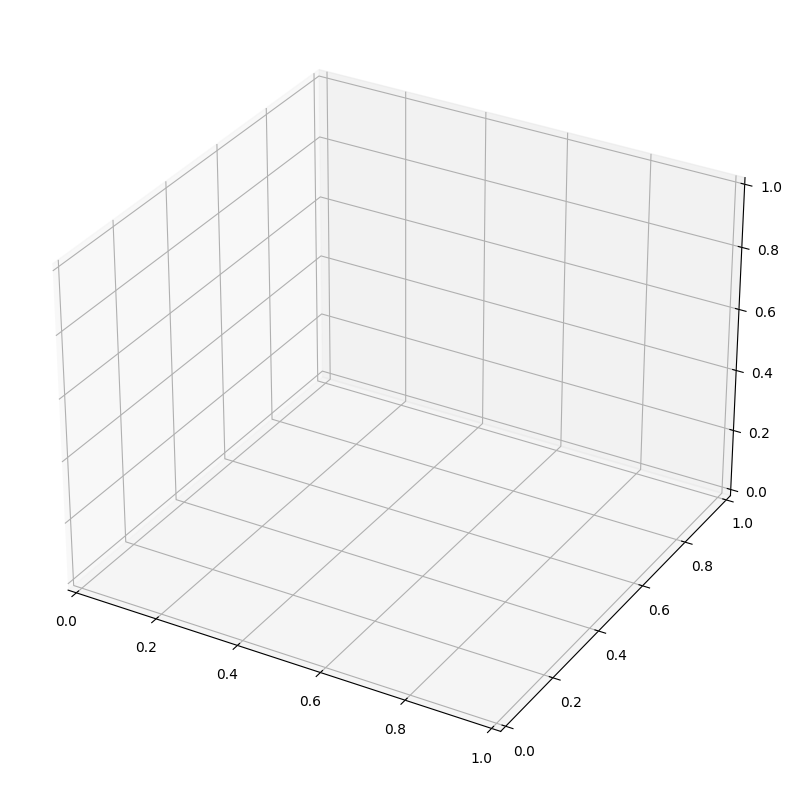

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/rr0/")
files = os.listdir()
data = pd.DataFrame(columns=['r0', 'replication', 'time', 'Count'])
for f in files:
    if 'dailycases2_rr0' in f:
        a = pd.read_csv(f, usecols=data.columns)
        a['time']=pd.to_datetime(a['time'])
        a['replication'] = a['replication'].astype(int)
        data = pd.concat([data, a], axis=0, ignore_index=True)
b = data["r0"].str.split(",", n = 1, expand = True)
b[0] = b[0].str.replace('[', '')
b[1] = b[1].str.replace(']', '')
b = b.rename({0:'R0', 1:'Rho'}, axis=1)
b['R0'] = b['R0'].astype(float)
b['Rho'] = b['Rho'].astype(float)
data = pd.concat((data,b[['R0', 'Rho']]), axis=1)
data = data.sort_values(['R0', 'Rho', 'replication', 'time'])
data.drop(['r0', 'time'], axis=1, inplace=True)
data = data.groupby(['R0', 'Rho', 'replication']).min().reset_index()
data = data.groupby(['R0', 'Rho']).size().reset_index()
data.rename({0:'Count'}, axis=1, inplace=True)
print(data)

r = pd.DataFrame(columns=['R0', 'Rho', 'Count'])
for i in [.5, 1, 1.5, 3, 5]:
    for j in [2, 5, 10]:
        c = data[(data['R0']==i)&(data['Rho']==j)]
        if c.shape[0]==0:
            r = r.append({'R0':i , 'Rho':j , 'Count':0}, ignore_index=True)
        else:
            r = r.append({'R0':i , 'Rho':j , 'Count':int(data.loc[(data['R0']==i)&(data['Rho']==j), 'Count'])}, ignore_index=True)

u = np.array([.5, 1, 1.5, 3, 5])
v = np.array([2, 5, 10])
u, v = np.meshgrid(u, v)
z = np.empty(u.shape)
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        z[i, j] = int(r[(r['R0']==u[i,j])&(r['Rho']==v[i,j])]['Count'])


z = z.astype(int)
# Plot the surface.

for ii in range(315, 315+1): #range(315,315+365,5):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 10))
    ax = Axes3D(fig)
    # Customize the z axis.
    ax.set_zlim(0, z.max())
    # ax.zaxis.set_major_locator(LinearLocator(10))
    ax.set_xlabel('Relative transmission factor', fontsize=19, labelpad=20)
    ax.set_ylabel('Basic reproductive rate', fontsize=19, labelpad=20)
    ax.set_zlabel('Number of replications with at least\n one outbreak (out of 40 replications)', fontsize=19, labelpad=20)
    surf = ax.plot_surface(v, u, z, cmap='YlOrRd',linewidth=1, edgecolor='black', alpha=0.75)
    ax.view_init(elev=30, azim=ii)
    # fig.savefig("/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/116/movie%d.png" % ii)

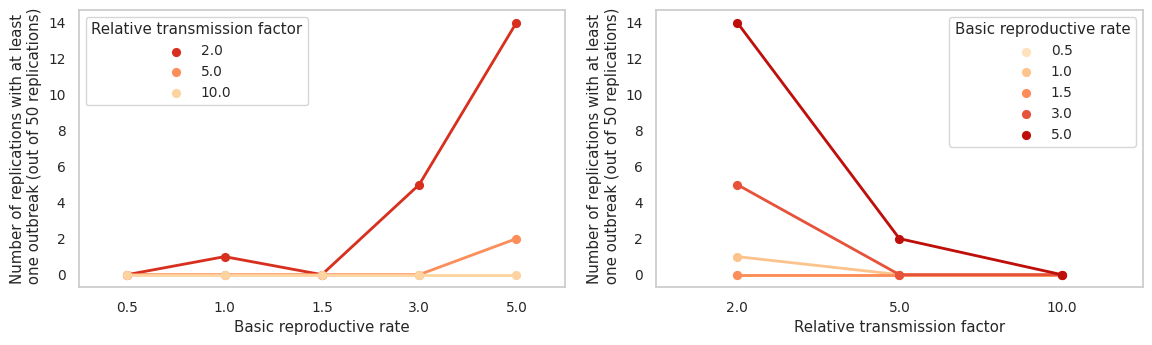

In [ ]:
r['R0'] = r['R0'].astype('float')
r['Count'] = r['Count'].astype(int)

r2 = r.copy()
r2 = r2.rename({'Rho':'Relative transmission factor'}, axis=1)
r2 = r2.rename({'R0':'Basic reproductive rate'}, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout(pad=3)
# sns.set(font_scale=.9)
sns.pointplot(data=r2, x=r2['Basic reproductive rate'], y=r2['Count'], hue=r2['Relative transmission factor'], palette='OrRd_r', ax=ax[0], markers='o', scale=.75)
# ax.axhline(y=9226, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.axvline(x=4, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.axvline(x=2.44, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.legend(['0', '0.25', '0.5', '0.75', '1'], title='Probability of\nsanitizing\nby individuals')
ax[0].set_xlabel('Basic reproductive rate')
ax[0].set_ylabel('Number of replications with at least\n one outbreak (out of 50 replications)')
#ax[0].grid(False)
# ax[0].annotate('50% reduction', xy=(1, 9226),  xycoords='data',
#             xytext=(-5, -30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))

sns.pointplot(data=r2, x=r2['Relative transmission factor'], y=r2['Count'], hue=r2['Basic reproductive rate'], palette='OrRd', ax=ax[1], markers='o', scale=.75)
# ax.axhline(y=9226, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.axvline(x=4, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.axvline(x=2.44, linewidth = 1, color='#b0362e', linestyle=(0, (5, 5)))
# ax.legend(['0', '0.25', '0.5', '0.75', '1'], title='Probability of\nsanitizing\nby individuals')
ax[1].set_xlabel('Relative transmission factor')
ax[1].set_ylabel('Number of replications with at least\n one outbreak (out of 50 replications)')
#ax[1].grid(False)
# ax[0].annotate('50% reduction', xy=(1, 9226),  xycoords='data',
#             xytext=(-5, -30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))

fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/Emergence.eps', dpi=1000)

Dynamics of disease

In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/nb/")
files = os.listdir()
im = pd.DataFrame(columns=['bike_generator', 'time', 'replication'])
for f in files:
    if 'micro_infections_nb' in f:
        a = pd.read_csv(f, usecols=['cyclist', 'start_of_infection', 'replication', 'bike_generator'])
        a['start_of_infection']=pd.to_datetime(a['start_of_infection'])
        a['replication'] = a['replication'].astype(int)
        a = a.groupby(['bike_generator', 'replication', 'start_of_infection']).size().reset_index()
        a.rename({0:'Count', 'start_of_infection':'time'}, axis=1, inplace=True)
        im = pd.concat([im, a], axis=0, ignore_index=True)
im = im.sort_values(['bike_generator', 'replication', 'time'])

os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/nb/")
files = os.listdir()
ip = pd.DataFrame(columns=['bike_generator', 'replication', 'time', 'Count'])
for f in files:
    if 'dailycases2_nb' in f:
        a = pd.read_csv(f, usecols=ip.columns)
        a['time']=pd.to_datetime(a['time'])
        ip = pd.concat([ip, a], axis=0, ignore_index=True)
ip = ip.sort_values(['bike_generator', 'replication', 'time'])

# This piece sums up the daily cases and micromobility cases
infected = pd.DataFrame(columns=ip.columns)
for i in ip['bike_generator'].unique():
    for j in ip['replication'].unique():
        for t in ip['time'].unique():
            aux1 = im[(im['bike_generator']==i)&
                                            (im['replication']==j)&
                                            (im['time']==t)]
            aux2 = ip[(ip['bike_generator']==i)&
                                      (ip['replication']==j)&
                                      (ip['time']==t)]
            if aux1.shape[0]!=0:
                infected = infected.append({'bike_generator':i, 'replication':j	,'time':t, 'Count': int(aux1['Count']) + int(aux2['Count'])}, ignore_index=True)
            else:
                infected = pd.concat((infected, aux2), axis=0)
infected['time']=pd.to_datetime(infected['time'])


Streaming output truncated to the last 5000 lines.
<ipython-input-17-f11629613d7e>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infected = infected.append({'bike_generator':i, 'replication':j	,'time':t, 'Count': int(aux1['Count']) + int(aux2['Count'])}, ignore_index=True)
<ipython-input-17-f11629613d7e>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infected = infected.append({'bike_generator':i, 'replication':j	,'time':t, 'Count': int(aux1['Count']) + int(aux2['Count'])}, ignore_index=True)
<ipython-input-17-f11629613d7e>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infected = infected.append({'bike_generator':i, 'replication':j	,'time':t, 'Count': int(aux1['Count']) + int(aux2['Count'])}, ignore_index=True)
<

In [ ]:
# Count the cumulative values for all
infected_cum = pd.DataFrame(columns=['bike_generator', 'replication', 'time', 'Count', 'countcum'])
for i in infected['bike_generator'].unique():
    for j in infected['replication'].unique():
        aux1 = infected[(infected['bike_generator']==i)&(infected['replication']==j)]
        aux1['countcum'] = aux1['Count'].cumsum()
        infected_cum = pd.concat((infected_cum, aux1), axis=0)
infected_cum['time']=pd.to_datetime(infected_cum['time'])
aux1 = infected_cum[infected_cum['time']==parse('2018-07-31 23:00:00')]
aux1['countcum'] = aux1['countcum'].astype(int)
total_infection = aux1.groupby('bike_generator').mean()['countcum'].reset_index()
total_infection['countcum_half'] = np.floor(total_infection['countcum']/2)

# Count the cumulative values for no mobility
ip_cum = pd.DataFrame(columns=['bike_generator', 'replication', 'time', 'Count', 'countcum'])
for j in ip['replication'].unique():
    aux1 = ip[(ip['bike_generator']==0)&(ip['replication']==j)]
    aux1['countcum'] = aux1['Count'].cumsum()
    ip_cum = pd.concat((ip_cum, aux1), axis=0)
ip_cum['time']=pd.to_datetime(ip_cum['time'])
aux1 = ip_cum[ip_cum['time']==parse('2018-07-31 23:00:00')]
aux1['countcum'] = aux1['countcum'].astype(int)
total_infection2 = aux1.groupby('bike_generator').mean()['countcum'].reset_index()
total_infection2['countcum_half'] = np.floor(total_infection2['countcum']/2)

<ipython-input-18-969ee5992890>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-18-969ee5992890>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-18-969ee5992890>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
# Count the cumulative values for micro and control separately
im_cum = pd.DataFrame(columns=['bike_generator', 'replication', 'time', 'Count', 'countcum'])
for i in im['bike_generator'].unique():
    for j in im['replication'].unique():
        aux1 = im[(im['bike_generator']==i)&(im['replication']==j)]
        aux1['countcum'] = aux1['Count'].cumsum()
        im_cum = pd.concat((im_cum, aux1), axis=0)
im_cum['time']=pd.to_datetime(im_cum['time'])
aux1 = im_cum[im_cum['time']==parse('2018-07-31 23:00:00')]
aux1['countcum'] = aux1['countcum'].astype(int)
total_infection = aux1.groupby('bike_generator').mean()['countcum'].reset_index()
total_infection['countcum_half'] = np.floor(total_infection['countcum']/2)
im_cum['countcum'] = im_cum['countcum'].astype(int)
print(im_cum[im_cum['time']=='2018-07-31 23:00:00'].groupby('bike_generator').mean()['countcum'])
print(im_cum[im_cum['time']=='2018-07-31 23:00:00'].groupby('bike_generator').std()['countcum'])
print(im_cum[im_cum['time']=='2018-07-31 23:00:00'].groupby('bike_generator').sem()['countcum'])

<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

bike_generator
0       5416.666667
50      8110.000000
100    10803.000000
300    21126.777778
500    32902.000000
Name: countcum, dtype: float64
bike_generator
0       82.857307
50     106.289698
100    142.835570
300    269.130906
500    492.160882
Name: countcum, dtype: float64
bike_generator
0       47.837689
50      47.534198
100    101.000000
300     89.710302
500    186.019328
Name: countcum, dtype: float64


<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['countcum'] = aux1['Count'].cumsum()
<ipython-input-19-4b1769ec2b17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

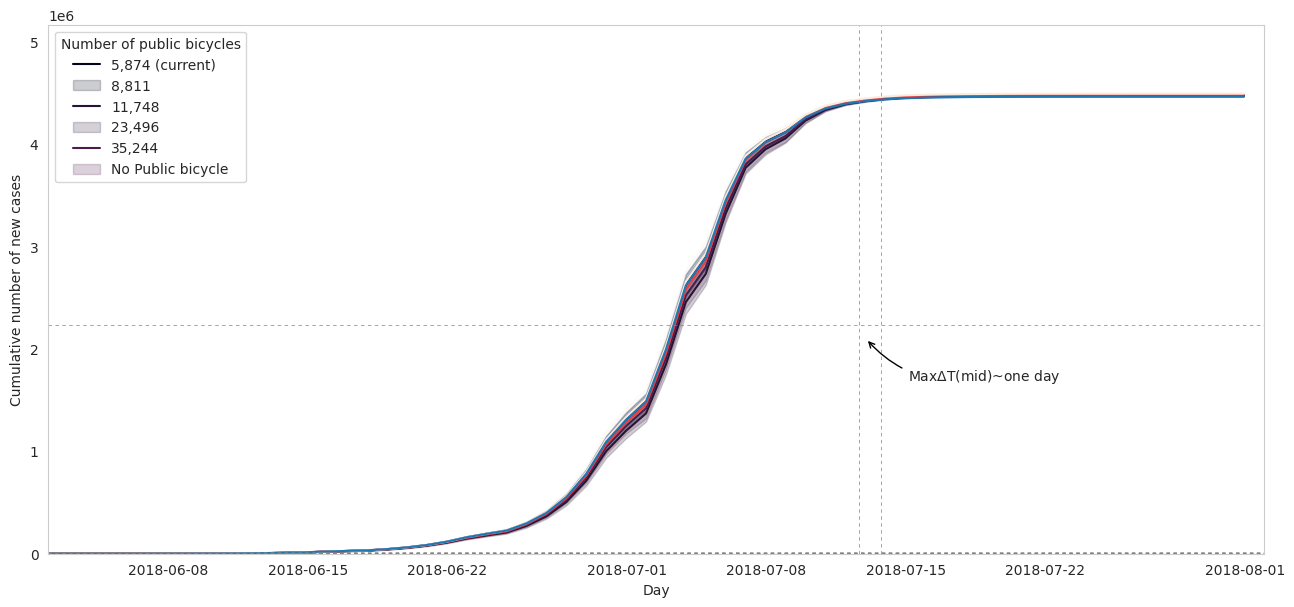

In [ ]:
# Acceleration
deltatime = dt.timedelta(days=1)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
plt.tight_layout(pad=1.5)
sns.lineplot(data=infected_cum, x = 'time', y='countcum', hue='bike_generator', palette="rocket", ax=ax, legend=False)
sns.lineplot(data=ip_cum, x = 'time', y='countcum', hue='bike_generator', ax=ax, legend=False)
ax.axvline(x=parse('2018-07-12 16:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
for idx, item in total_infection.iterrows():
     ax.axhline(y=int(item['countcum_half']), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axhline(y=int(total_infection2.loc[0, 'countcum_half']), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-13 18:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.set_xlabel('Day')
ax.set_ylabel('Cumulative number of new cases')
ax.set(xlim=([ip_cum['time'][0], ip_cum['time'].iloc[-1] + deltatime]))
ax.set(ylim=(-100, people.shape[0]))
ax.annotate('Max'+r'$\Delta$'"T(mid)~one day", xy=(parse('2018-07-13 00:00:00'), 2100000),  xycoords='data',
            xytext=(30, -30), textcoords='offset points',arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.legend(['5,874 (current)', '8,811', '11,748', '23,496', '35,244', 'No Public bicycle'], title='Number of public bicycles')
# fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/R1.1.1.jpeg', dpi=1000)

Number of bikes

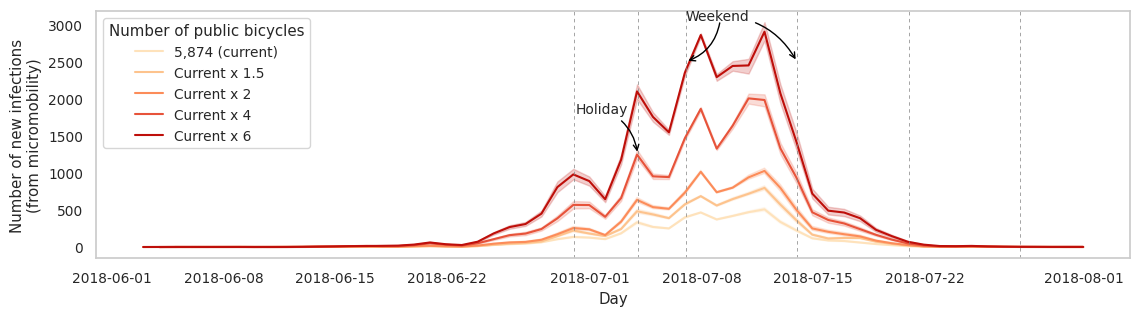

In [ ]:
mask = im['bike_generator'] == 0
im.loc[mask, 'bike_generator'] = '5,874 (current)'
mask = im['bike_generator'] == 50
im.loc[mask, 'bike_generator'] = 'Current x 1.5'
mask = im['bike_generator'] == 100
im.loc[mask, 'bike_generator'] = 'Current x 2'
mask = im['bike_generator'] == 300
im.loc[mask, 'bike_generator'] = 'Current x 4'
mask = im['bike_generator'] == 500
im.loc[mask, 'bike_generator'] = 'Current x 6'

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.tight_layout(pad=4)

sns.lineplot(data=im, x = 'time', y='Count', hue='bike_generator', palette="OrRd")
ax.axvline(x=parse('2018-06-30 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-04 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-07 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-14 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-21 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-28 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))

ax.set_xlabel('Day')
ax.set_ylabel('Number of new infections\n(from micromobility)')
ax.annotate('Holiday', xy=(parse('2018-07-04 00:00:00'), 1250),  xycoords='data',
            xytext=(-45, 30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('Weekend', xy=(parse('2018-07-14 00:00:00'), 2500),  xycoords='data',
            xytext=(-80, 30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('', xy=(parse('2018-07-07 00:00:00'), 2500),  xycoords='data',
            xytext=(25, 30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
sns.move_legend(ax, "upper left", title='Number of public bicycles')
#ax.legend(['5,874 (current)', '8,811', '11,748', '23,496', '35,244'], title='Number of public bicycles')
fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/nb1.eps', dpi=1000)


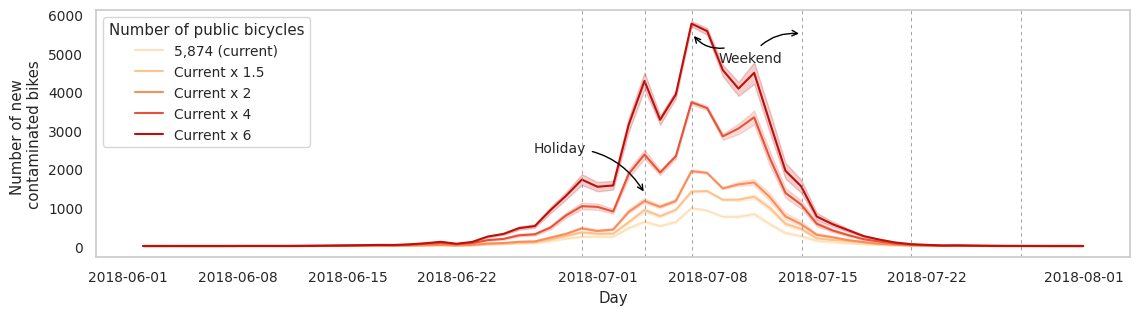

In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/nb/")
files = os.listdir()
cp = pd.DataFrame(columns=['bike_generator', 'replication', 'start_of_contamination', 'Count'])
for f in files:
    if 'contaminated_bikes2' in f:
        a = pd.read_csv(f, usecols=cp.columns)
        a['start_of_contamination']=pd.to_datetime(a['start_of_contamination'])
        cp = pd.concat([cp, a], axis=0, ignore_index=True)
cp.rename({'start_of_contamination':'time'}, axis=1, inplace=True)

cp['time']=pd.to_datetime(cp['time'])

mask = cp['bike_generator'] == 0
cp.loc[mask, 'bike_generator'] = '5,874 (current)'
mask = cp['bike_generator'] == 50
cp.loc[mask, 'bike_generator'] = 'Current x 1.5'
mask = cp['bike_generator'] == 100
cp.loc[mask, 'bike_generator'] = 'Current x 2'
mask = cp['bike_generator'] == 300
cp.loc[mask, 'bike_generator'] = 'Current x 4'
mask = cp['bike_generator'] == 500
cp.loc[mask, 'bike_generator'] = 'Current x 6'

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.tight_layout(pad=4)
sns.set_style("whitegrid", {'axes.grid' : False})
# sns.set(font_scale=.9)
sns.lineplot(data=cp, x = 'time', y='Count', hue='bike_generator', palette="OrRd")
ax.axvline(x=parse('2018-06-30 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-04 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-07 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-14 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-21 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-28 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))

#ax.legend(['5,874 (current)', '8,811', '11,748', '23,496', '35,244'], title='Number of public bicycles')
ax.set_xlabel('Day')
ax.set_ylabel('Number of new \ncontaminated bikes')
ax.annotate('Holiday', xy=(parse('2018-07-04 00:00:00'), 1350),  xycoords='data',
            xytext=(-80, 30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('Weekend', xy=(parse('2018-07-14 00:00:00'), 5500),  xycoords='data',
            xytext=(-60, -20), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('', xy=(parse('2018-07-07 00:00:00'), 5500),  xycoords='data',
            xytext=(25, -10), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
sns.move_legend(ax, "upper left", title='Number of public bicycles')
fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/nb2.eps', dpi=1000)

Inactivation time

<ipython-input-80-bab8abeebf83>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t = imsvt.groupby(['svt', 'replication']).sum()['Count'].reset_index()


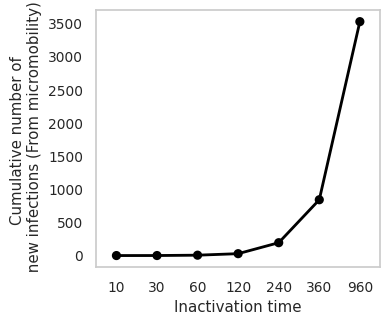

In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/svt/")
files = os.listdir()
imsvt = pd.DataFrame(columns=['svt', 'replication', 'start_of_infection', 'Count'])
for f in files:
    if 'micro_infections2' in f:
        a = pd.read_csv(f, usecols=imsvt.columns)
        a['start_of_infection']=pd.to_datetime(a['start_of_infection'])
        imsvt = pd.concat([imsvt, a], axis=0, ignore_index=True)
imsvt.rename({'start_of_infection':'time'},axis=1, inplace=True)
t = imsvt.groupby(['svt', 'replication']).sum()['Count'].reset_index()
t1 = t.groupby('svt').mean()['Count'].reset_index()
t1['sem'] = t.groupby('svt').sem()['Count'].reset_index()['Count']
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.1))
plt.tight_layout(pad=4)
sns.set_style("whitegrid", {'axes.grid' : False})
# sns.set(font_scale=.9)
sns.pointplot(data=t1, x='svt', y='Count', ax=ax, color='black', scale=.75)
ax.set_xlabel('Inactivation time')
ax.set_ylabel('Cumulative number of \n new infections (From micromobility)')
#ax.set_xticklabels(['10 Minutes', '30 Minutes', '1 Hour', '2 Hours', '4 Hours', '6 Hours', '16 Hours'])
fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/R.A.survival2.eps', dpi=1000)

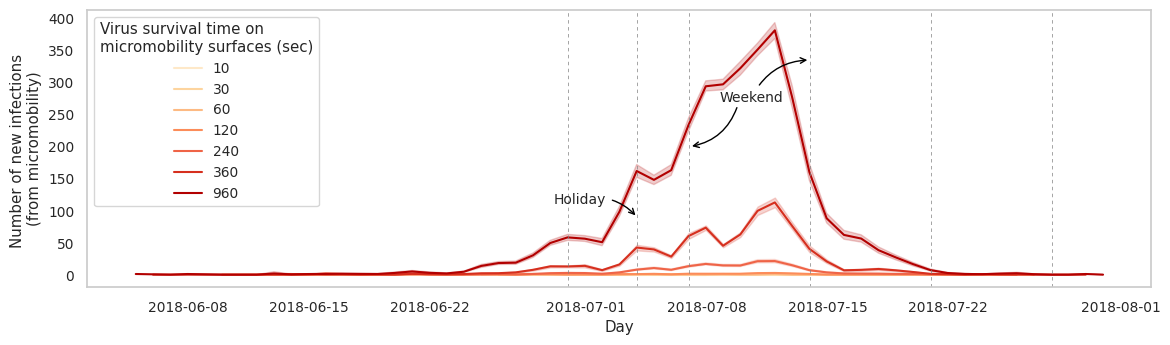

In [ ]:
imsvt['svt'] = imsvt['svt'].astype(str)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.tight_layout(pad=3)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.lineplot(data=imsvt, x = 'time', y='Count', hue='svt', palette="OrRd")
ax.axvline(x=parse('2018-06-30 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-04 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-07 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-14 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-21 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
ax.axvline(x=parse('2018-07-28 00:00:00'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))

#ax.legend(['10 Minutes', '30 Minutes', '1 Hour', '2 Hours', '4 Hours', '6 Hours', '16 Hours'], title='Virus survival time on\nmicromobility surfaces')
ax.set_xlabel('Day')
ax.set_ylabel('Number of new infections \n(from micromobility)')
ax.annotate('Holiday', xy=(parse('2018-07-04 00:00:00'), 90),  xycoords='data',
            xytext=(-60, 10), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('Weekend', xy=(parse('2018-07-14 00:00:00'), 335),  xycoords='data',
            xytext=(-65, -30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
ax.annotate('', xy=(parse('2018-07-07 00:00:00'), 200),  xycoords='data',
            xytext=(35, 30), textcoords='offset points', fontsize=10, arrowprops=dict(color='black', arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
sns.move_legend(ax, "upper left",title='Virus survival time on\nmicromobility surfaces (sec)')
fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/R.A.survival.eps', dpi=1000)

Space

In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/rdl/")
files = os.listdir()
imrdl = pd.DataFrame(columns=['iip', 'start_of_contamination', 'end_of_contamination', 'replication'])
for f in files:
    if 'contaminated_bikes_rdl' in f:
        a = pd.read_csv(f, usecols=['bike_id', 'start_of_contamination', 'end_of_contamination', 'replication', 'iip'])
        a['start_of_contamination']=pd.to_datetime(a['start_of_contamination'])
        a['end_of_contamination']=pd.to_datetime(a['end_of_contamination'])
        a['replication'] = a['replication'].astype(int)
        imrdl = pd.concat([imrdl, a], axis=0, ignore_index=True)
imrdl = imrdl.sort_values(['bike_id', 'replication', 'start_of_contamination', 'end_of_contamination'])

In [ ]:
# # Run this only once
# for rep in imrdl['replication'].unique()[22:]:
#     print('Processing replication: ', rep)
#     r = imrdl[imrdl['replication']==rep]
#     start_time = parse('2018-06-01 00:00:00')
#     end_time = parse('2018-08-01 00:00:00')
#     deltatime = dt.timedelta(minutes=60*24)
#     collector = pd.DataFrame(columns=['rep', 'station_id', 'time', 'count'])

#     for id in list(Divvy_Stations['ID']):
#         for t in range(61):
#             df = pd.DataFrame([[rep, id, start_time + t*deltatime, 0]], columns=collector.columns)
#             collector = pd.concat([collector, df], axis=0, ignore_index=True)

#     for idx, row in r.iterrows():
#         aux = divvy_data[divvy_data['bike_id'] == row['bike_id']]
#         mask1 = aux[(aux['start_time']<str(row['start_of_contamination'])) & \
#                 (aux['end_time']>str(row['start_of_contamination']))]
#         s1 = list(np.unique(list(mask1['end_station_id'])))
#         mask2 = aux[(aux['start_time'] > str(row['start_of_contamination'])) & \
#                 (aux['end_time'] < str(row['end_of_contamination']))]
#         s2 = list(np.unique(list(mask2['start_station_id']) + list(mask2['end_station_id'])))
#         mask3 = aux[(aux['start_time'] < str(row['end_of_contamination'])) & (
#                     aux['end_time'] > str(row['end_of_contamination']))]
#         s3 = list(np.unique(list(mask3['start_station_id'])))
#         for st in s1:
#             mask = (collector['station_id']==st)&(collector['rep']==rep)&(collector['time']==str(row['end_of_contamination'])[:10])
#             collector.loc[mask,'count'] +=1
#         for st in s2:
#             mask = (collector['station_id']==st)&(collector['rep']==rep)&(collector['time']==str(row['end_of_contamination'])[:10])
#             collector.loc[mask,'count'] +=1
#         for st in s3:
#             mask = (collector['station_id']==st)&(collector['rep']==rep)&(collector['time']==str(row['end_of_contamination'])[:10])
#             collector.loc[mask,'count'] +=1

#     collector.to_csv('/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/station_ranking_' + str(rep) +'.csv')

In [ ]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Thesis/Thesis_colabs/results/")
files = os.listdir()

cols=['rep', 'station_id', 'time', 'count']
aux = list(filter(lambda f: f.endswith('.csv') and 'station_ranking' in f, files))
station_ranking = pd.DataFrame(columns=cols)
for file in aux:
    f = pd.read_csv(file, usecols=cols)
    f = f.reset_index(drop=True)
    station_ranking = pd.concat([station_ranking, f], axis=0, ignore_index=True)
    print(file, 'is added...')

station_ranking_0.csv is added...
station_ranking_1.csv is added...
station_ranking_2.csv is added...
station_ranking_3.csv is added...
station_ranking_4.csv is added...
station_ranking_5.csv is added...
station_ranking_6.csv is added...
station_ranking_7.csv is added...
station_ranking_8.csv is added...
station_ranking_9.csv is added...
station_ranking_10.csv is added...
station_ranking_11.csv is added...
station_ranking_12.csv is added...
station_ranking_13.csv is added...
station_ranking_14.csv is added...
station_ranking_15.csv is added...
station_ranking_16.csv is added...
station_ranking_17.csv is added...
station_ranking_18.csv is added...
station_ranking_19.csv is added...
station_ranking_20.csv is added...
station_ranking_21.csv is added...
station_ranking_22.csv is added...
station_ranking_23.csv is added...
station_ranking_24.csv is added...
station_ranking_25.csv is added...
station_ranking_26.csv is added...
station_ranking_27.csv is added...
station_ranking_28.csv is adde

<ipython-input-84-f775d74d3f0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['time'] = pd.to_datetime(a['time'])
<ipython-input-84-f775d74d3f0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['time'] = pd.to_datetime(a['time'])
<ipython-input-84-f775d74d3f0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

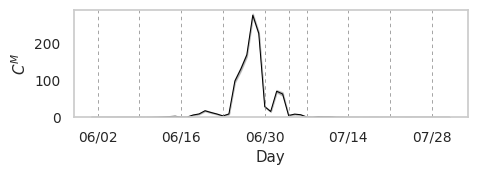

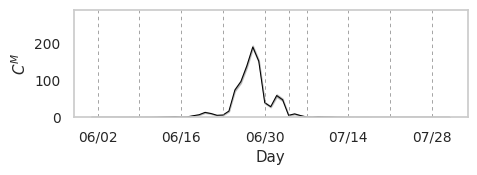

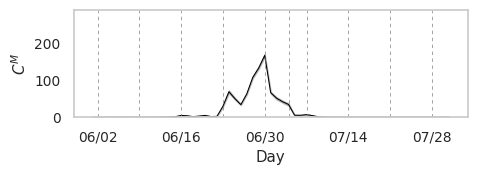

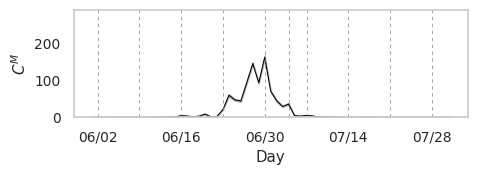

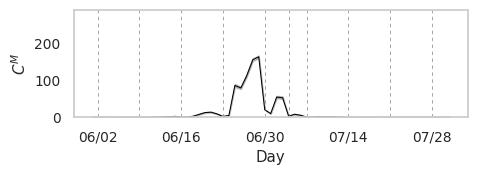

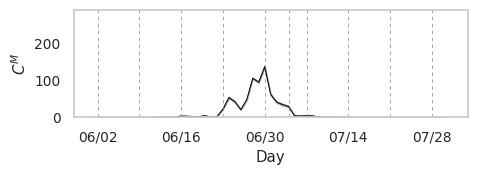

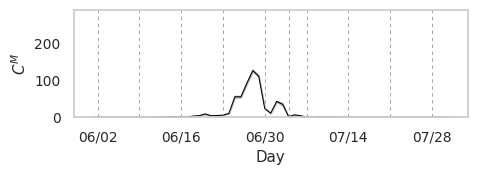

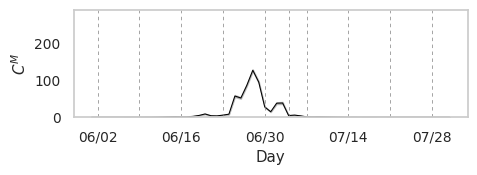

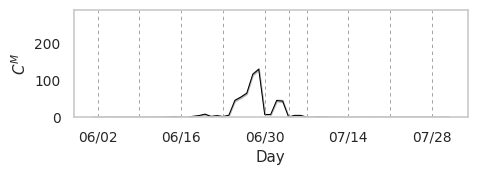

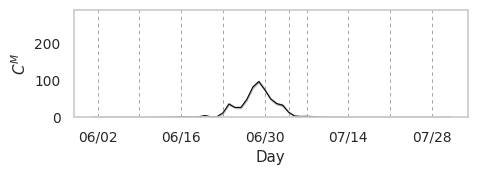

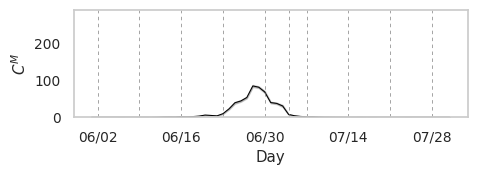

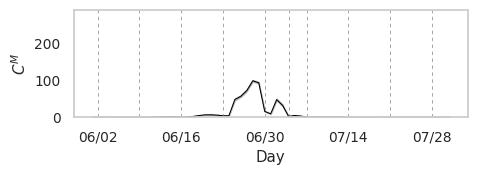

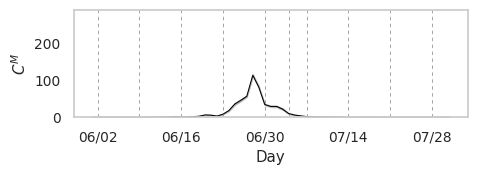

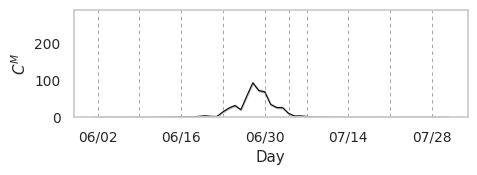

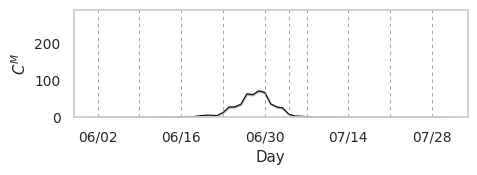

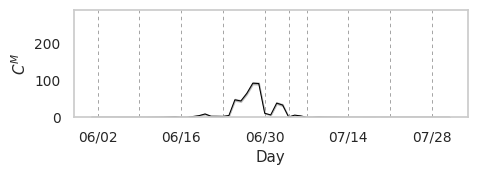

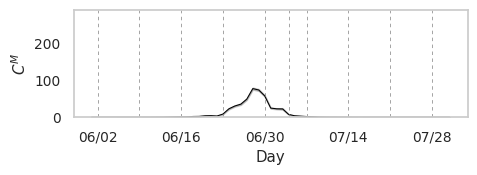

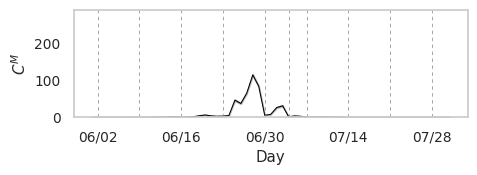

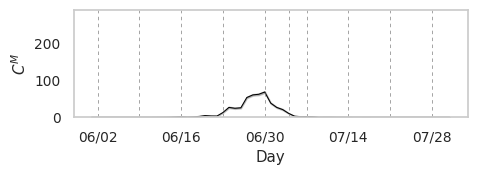

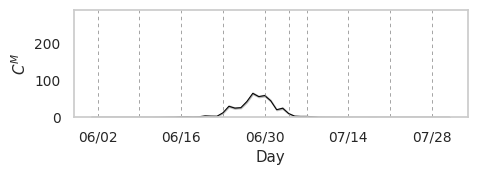

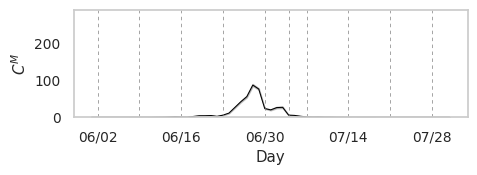

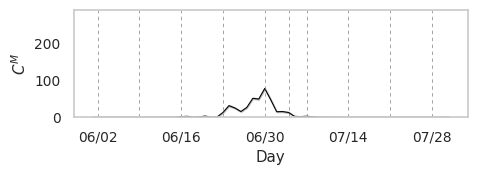

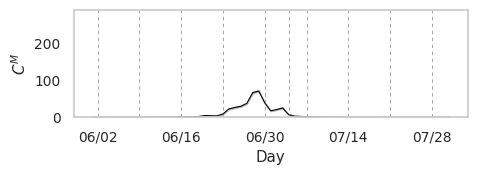

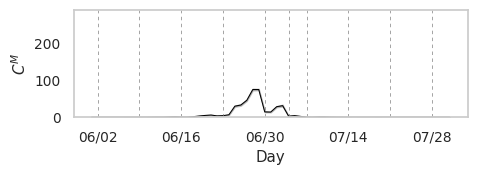

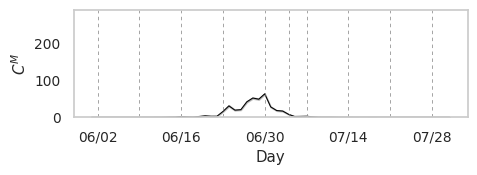

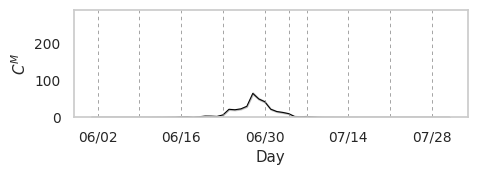

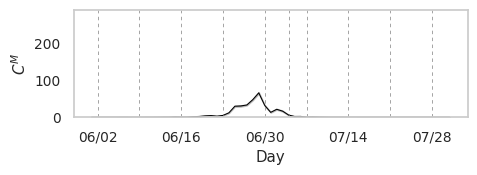

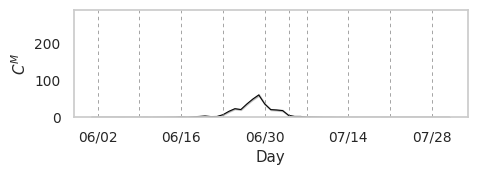

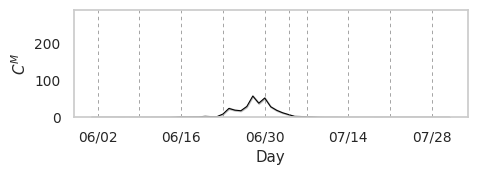

In [ ]:
ids = [192, 77, 35, 268, 91, 177, 81, 43, 287, 85, 133, 174, 195, 90, 176, 283, 110,
           100, 94, 289, 211, 76, 59, 48, 141,313, 74, 140, 334]
for id in ids:
    a = station_ranking[station_ranking['station_id']==id]
    a['time'] = pd.to_datetime(a['time'])
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    plt.tight_layout(pad=2)
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.lineplot(data=a, x = 'time', y='count', estimator='mean', errorbar=('ci', 95), color='black', linewidth=0.75)
    ax.axvline(x=parse('2018-06-02'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-06-09'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-06-16'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-06-23'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-06-30'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-07-04'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-07-07'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-07-14'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-07-21'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))
    ax.axvline(x=parse('2018-07-28'), linewidth = 0.5, color='gray', linestyle=(0, (5, 5)))

    #ax.legend(['10 Minutes', '30 Minutes', '1 Hour', '2 Hours', '4 Hours', '6 Hours', '16 Hours'], title='Virus survival time on\nmicromobility surfaces')
    ax.set_xlabel('Day')
    ax.set_ylabel('$C^M$')
    plt.xticks(['2018-06-02', '2018-06-16', '2018-06-30', '2018-07-14', '2018-07-28'], ['06/02', '06/16', '06/30', '07/14', '07/28'])
    ax.set_ylim(0, 290)
    fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/timeseries_' + str(id) + '.eps', dpi=600)


In [ ]:
Divvy_Stations_Thiessen[Divvy_Stations_Thiessen['ID']==268].plot()

In [ ]:
Divvy_Stations_Thiessen

In [ ]:
c.sort_values(['2018-07-31'], ascending=False).head(50)

In [ ]:
a = station_ranking.groupby(['station_id', 'time']).mean()['count'].reset_index()
b = a.set_index('time').groupby('station_id').apply(lambda x: x['count'].cumsum()).reset_index()
for st in Divvy_Stations['ID']:
    if st not in b['station_id'].unique():
        print(st)
        b = b.append({'station_id':st}, ignore_index=True)
b = b.fillna(0)
c = b.merge(Divvy_Stations_Thiessen[['ID', 'geometry', 'Total_Dock']], left_on='station_id', right_on='ID', how='left')

In [ ]:
xmin, ymin, xmax, ymax = create_animation2.total_bounds
print(xmin)
print(ymin)
print(xmax)
print(ymax)

-9772465.2732
5120302.908399999
-9744850.3995
5165457.163999997


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


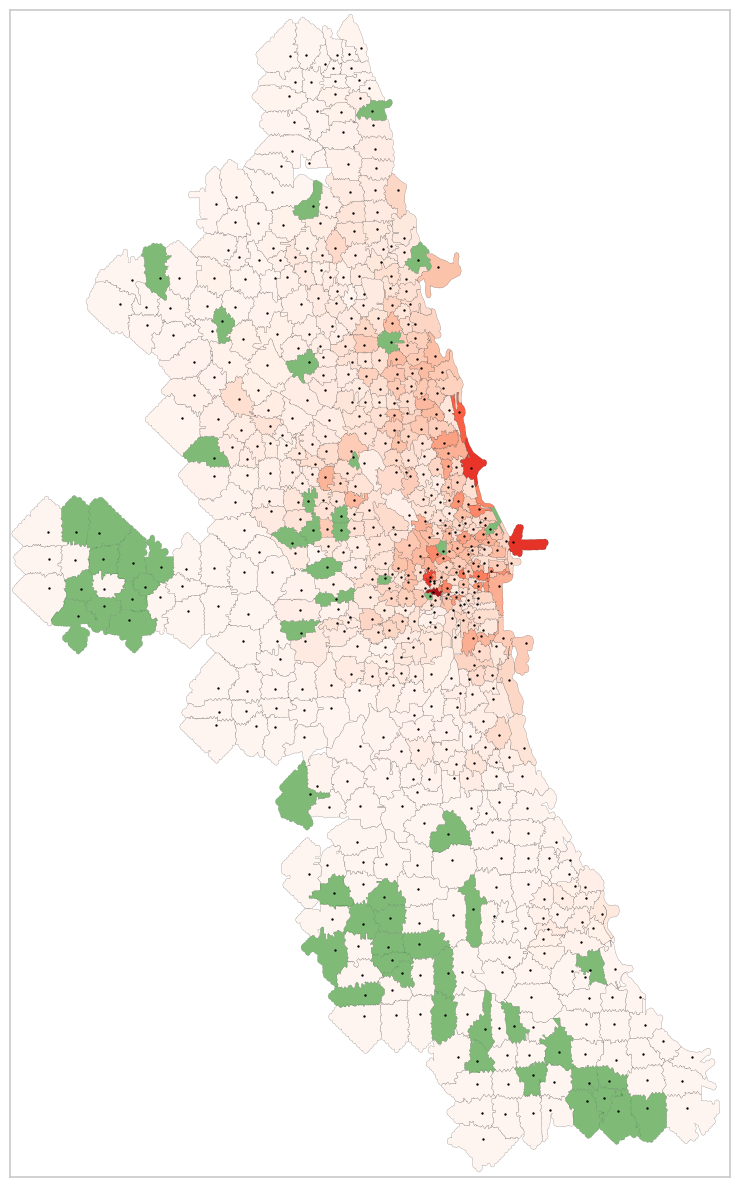

In [ ]:
 # from matplotlib import colors
# from splot.esda import lisa_cluster
# from libpysal.weights import Queen, Rook, KNN
# from esda.moran import Moran
# from esda.moran import Moran_Local
create_animation = c.copy()
# create_animation = create_animation.set_index('station_id')
# create_animation2 = create_animation.merge(Divvy_Stations_Thiessen[['ID', 'geometry', 'Total_Dock']], left_on=create_animation['station_id'], right_on='ID', how='left')
create_animation2 = gpd.GeoDataFrame(create_animation.drop('ID', axis=1))
create_animation2.set_crs(epsg=3857, inplace=True)

start_time = parse('2018-06-02')
end_time = parse('2018-08-01')
deltatime = dt.timedelta(minutes=60*24)
dates = [start_time + t*deltatime for t in range(60)]
dates = [item.strftime('%Y-%m-%d') for item in dates]
vmax = 1378
vmin = 0
for item in pd.date_range(start="2018-07-31",end="2018-07-31"):
    item = item.strftime('%Y-%m-%d')
    fig, ax = plt.subplots(1, 1, figsize=(9, 12))#10,12 & 5*5
    plt.tight_layout(pad=0)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = create_animation2.plot(column = item, cmap='Reds', ax=ax, edgecolor='black', linewidth=0.1, legend=False, vmin=vmin, vmax=vmax)

    #create_animation2[create_animation2[item]==-1].plot(column = item, color='gray', ax=ax, edgecolor='white', linewidth=0.1, legend=False)
    if item == parse('2018-07-31').strftime('%Y-%m-%d'):
        create_animation2[create_animation2['2018-07-31']==0].plot(column = item, color='green', ax=ax, edgecolor='white', linewidth=0.1, legend=False, alpha=.5)
    #ax.title.set_text('Date: '+ item)
    Divvy_Stations.plot(color='black', ax=ax, markersize=0.5)
    #road.plot(color='grey', ax=ax, alpha=0.1, linewidth=0.02)
    ax.set_xlim([Divvy_Stations.geometry.x.min()-1500, Divvy_Stations.geometry.x.max()+1500])
    ax.set_ylim([Divvy_Stations.geometry.y.min()-1500, Divvy_Stations.geometry.y.max()+1500])
    # ax.set_xlim([-9757000, -9751500])#-9772465, -9744850
    # ax.set_ylim([5142500, 5149500])# 5120302, 5165457
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # for pos in ['right', 'top', 'bottom', 'left']:
    #     plt.gca().spines[pos].set_visible(False)


    fig.savefig('/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/space_' + item + '.eps', dpi=1000)

In [ ]:
item = '2018-07-31'
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
plt.tight_layout()
f = create_animation2.plot(column = item, cmap='RdBu_r', ax=ax, edgecolor='white', linewidth=0.1, legend=True, vmin=vmin, vmax=vmax)
create_animation2[create_animation2[item]==-1].plot(column = item, color='gray', ax=ax, edgecolor='white', linewidth=0.1, legend=False)

In [ ]:
from splot.esda import lisa_cluster
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from esda.moran import Moran_Local

item = '2018-07-31'
W = Queen.from_dataframe(create_animation2)
W.transform = 'r'
moran_ntl = Moran(create_animation2[item], W)
print('moran_ntl' + item + ': ' + str(moran_ntl.I))
moran_loc = Moran_Local(create_animation2[item], W)
p = lisa_cluster(moran_loc, create_animation2, p=0.05, figsize=(9, 9))
plt.title('Cluster Map of ' + item, size=20)
plt.show()
# plt.savefig(
#     'G:/backupC27152020/Population_Displacement_Final/Results/Model/Cluster Map of Nightlight Residuals.png',
#     dpi=500, bbox_inches='tight')

# #1 HH, 2 LH, 3 LL, 4 HL
# cluster = _viz_utils.moran_hot_cold_spots(moran_loc, p=0.05)
# aux = pd.DataFrame(cluster)
# aux.rename({0:item}, inplace=True, axis=1)
# aux.loc[aux[item] == 0, [item]] = 'NS'
# aux.loc[aux[item]==1,[item]] = 'HH'
# aux.loc[aux[item]==2,[item]] = 'LH'
# aux.loc[aux[item]==3,[item]] = 'LL'
# aux.loc[aux[item]==4,[item]] = 'HL'
# cluster = pd.concat((ntl_scale_NTL2, aux), axis=1)
# cluster = pd.get_dummies(cluster)

In [ ]:
people.T.drop_duplicates()

Visualize network

TypeError: ignored

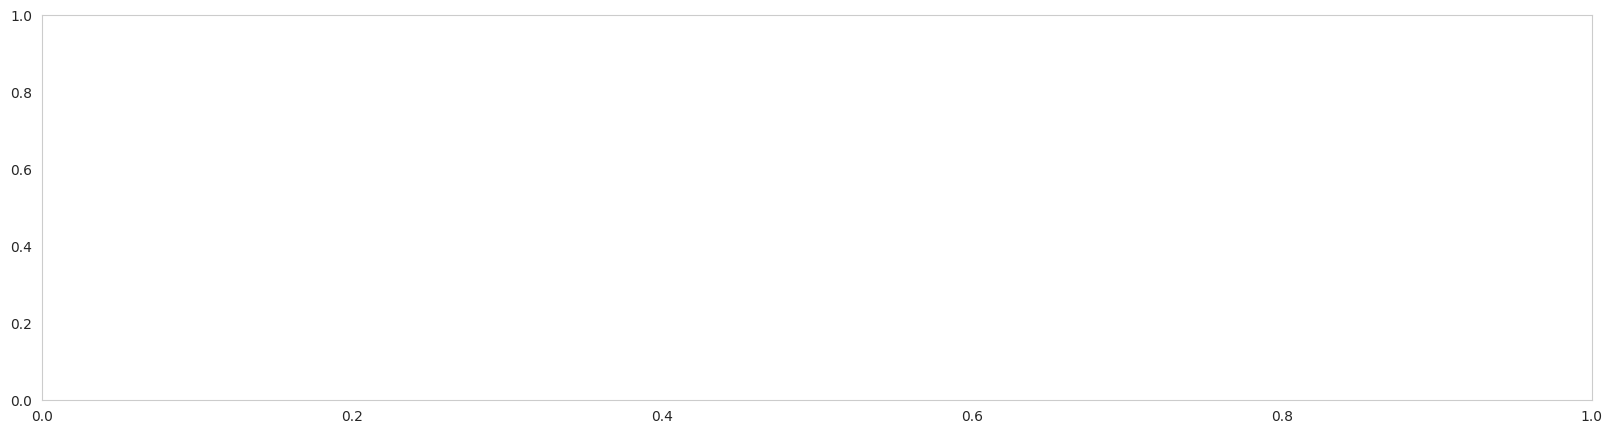

In [ ]:
# household types for census tract '17031491400'
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
lbs=['h&w(no<18)', 'h&w(ch<18)', 'm(no<18)', 'm(ch<18)', 'f(no<18)', 'f(ch<18)', 'non-family', 'm<65', 'm>65', 'f<65', 'f>65', 'group_quart']
aux_real = dp[dp.index=='17031491400'].iloc[:,154:169].drop(['DP0130001', 'DP0130002', 'DP0130003', 'DP0130011'], axis=1)
aux_real = pd.concat((aux_real, dp[dp.index=='17031491400'].loc[:,'DP0120014']), axis=1)
people = people.T.drop_duplicates().T
aux_model = people[people['GEOID10_hhold']==17031491400].groupby(['htype']).size()
aux_model = aux_model.set_index('htype').transpose()
aux_model.columns = lbs
sns.barplot(data = aux_real, ax=ax, color='blue')
sns.barplot(data = aux_model, ax=ax, color='red', alpha=.5)
ax.set_xticklabels(lbs)

In [ ]:
# Only inside
p = list(people[people['GEOID10_hhold']==17031843500].index)
test = G.new_vertex_property('bool')
test.get_array()[:] = 0
test.get_array()[p] = 1
G.vertex_properties["test"] = test

In [ ]:
# With outside links
p = list(people[people['index'].str[:11]=='17031843500'].index)
pp = []
for v in G.get_vertices()[p]:
    if list(G.get_out_neighbors(v)) != []:
        pp = pp + list(G.get_out_neighbors(v))
pp = list(np.unique(pp))
test = G.new_vertex_property('bool')
test.get_array()[:] = 0
test.get_array()[pp] = 1
G.vertex_properties["test"] = test

In [ ]:
G.set_vertex_filter(test)
pos = sfdp_layout(G)
graph_draw(G, pos, output_size=(1000, 1000), vertex_size=1, edge_pen_width=1.2, edge_color=etype, output ='/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/g1_all2.png')
s = len(gt.util.find_edge(G, etype, 1)) + len(gt.util.find_edge(G, etype, 2)) + len(gt.util.find_edge(G, etype, 3))
print(np.round((len(gt.util.find_edge(G, etype, 1))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 2))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 3))/s)*100))
G.set_vertex_filter(None)
G.set_edge_filter(None)
plt.legend(['Home', 'School, Work'])

In [ ]:
G.set_vertex_filter(None)
G.set_edge_filter(None)
s = len(gt.util.find_edge(G, etype, 1)) + len(gt.util.find_edge(G, etype, 2)) + len(gt.util.find_edge(G, etype, 3))
print(np.round((len(gt.util.find_edge(G, etype, 1))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 2))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 3))/s)*100))
print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
counts,bins = gt.stats.distance_histogram(G,samples=1000)
print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

G.set_edge_filter(home)
s = len(gt.util.find_edge(G, etype, 1)) + len(gt.util.find_edge(G, etype, 2)) + len(gt.util.find_edge(G, etype, 3))
print(np.round((len(gt.util.find_edge(G, etype, 1))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 2))/s)*100))
print(np.round((len(gt.util.find_edge(G, etype, 3))/s)*100))
print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
counts,bins = gt.stats.distance_histogram(G,samples=1000)
print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

In [ ]:
G.set_vertex_filter(test)
pos = sfdp_layout(G)
graph_draw(G, pos, output_size=(700, 700), vertex_size=1, edge_pen_width=1.2, edge_color=etype, output = '/content/gdrive/MyDrive/ColabNotebooks/Thesis/figures/g1_home.jpeg')

In [ ]:
#prepare a 2-hops (FoF) ego network
g = nx.read_gml('gdrive/MyDrive/ColabNotebooks/Thesis/sources/k4p3_test.gml')
#start with a single individual
i0 = '17031840300i3'
#get friends + friends of friends (FoF)
hop2 = set().union(*[[n]+g.neighbors(n) for n in g.neighbors(i0)])
g2 = nx.Graph(g.edges(hop2,data=True))

hholdm = [i0] + [k for k,v in g[i0].items() if v['etype']=='hhold']
hhold_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'hhold']
work_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'work']
school_edges = [e for e in g2.edges(hholdm,data=True) if e[2]['etype'] == 'school']

In [ ]:
# draw the graph
labels = people.loc[[i0] + g.neighbors(i0)] #[k for k,v in g[i0].items()]
labels = (labels['age'].astype(str)+','+labels['sex']).to_dict()

pos = nx.spring_layout(g2)

fig,ax = plt.subplots();
blues = plt.get_cmap('Blues')
nx.draw_networkx_nodes(g2,pos,nodelist=[i0],alpha=.5)
nx.draw_networkx(g2,pos,nodelist=hop2, node_color=[1]*len(hop2),cmap=blues,vmin=0,vmax=1,alpha=0.15,
                        node_size=50,font_size=13, labels=labels, ax=ax)

nx.draw_networkx_edges(g2,pos, edge_color='red',edgelist = hhold_edges,width=2,alpha=.3,ax=ax)
nx.draw_networkx_edges(g2,pos, edge_color='blue',edgelist = school_edges,width=2,alpha=.3,ax=ax)
nx.draw_networkx_edges(g2,pos, edge_color='green',edgelist = work_edges,width=2,alpha=.3,ax=ax)
ax.axis('off');

In [ ]:
with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population2.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

hhold = gt.load_graph('gdrive/MyDrive/ColabNotebooks/Thesis/sources/hhold-2.gml')
work = gt.load_graph('gdrive/MyDrive/ColabNotebooks/Thesis/sources/work-2.gml')
school = gt.load_graph('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school-2.gml')

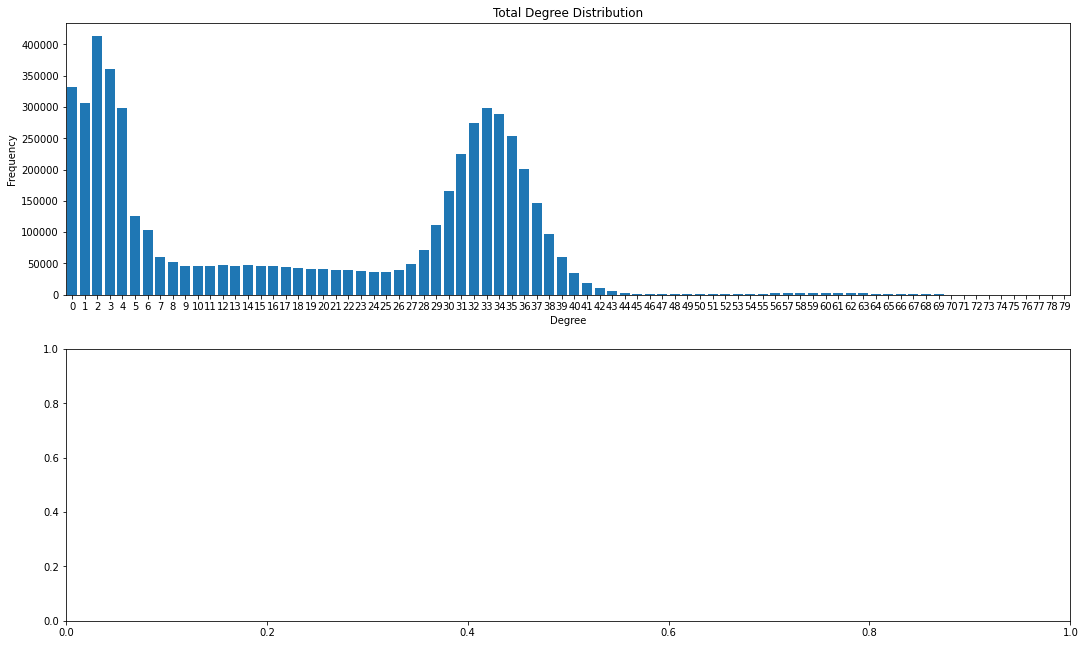

In [ ]:
f,axes = plt.subplots(nrows=2, ncols=1,figsize=(18,11))
ax = axes[0]
counts,bins = gt.stats.vertex_hist(G, 'total')
ax.bar(bins[:-1],counts,tick_label=bins[:-1])
ax.set(xlabel='Degree',ylabel='Frequency',#yscale='log',
       title='Total Degree Distribution',xlim=(-0.5,len(counts)-0.5));


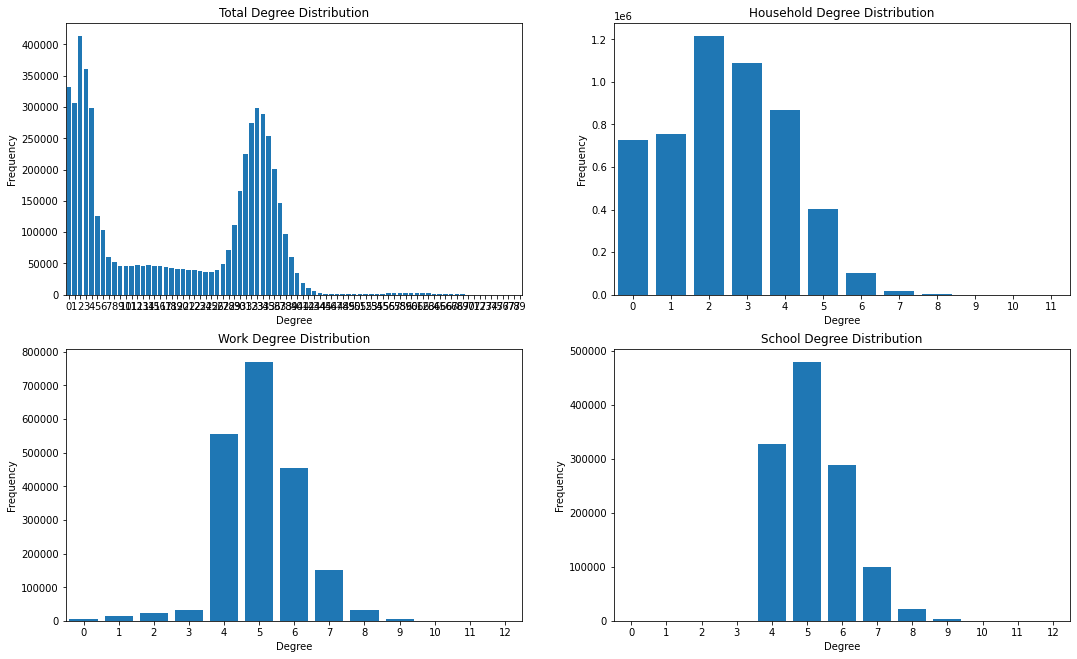

In [ ]:
f,axes = plt.subplots(nrows=2, ncols=2,figsize=(18,11))

ax = axes[0,0]
counts,bins = gt.stats.vertex_hist(G, 'total')
ax.bar(bins[:-1],counts,tick_label=bins[:-1])
ax.set(xlabel='Degree',ylabel='Frequency',#yscale='log',
       title='Total Degree Distribution',xlim=(-0.5,len(counts)-0.5));

ax = axes[0,1]
counts,bins = gt.stats.vertex_hist(hhold, 'total', float_count=False)
counts[0] = G.num_vertices() - sum(counts)
ax.bar(bins[:-1],counts,tick_label=bins[:-1])
ax.set(xlabel='Degree',ylabel='Frequency',#yscale='log',
       title='Household Degree Distribution',xlim=(-0.5,len(counts)-0.5));

ax = axes[1,0]
counts,bins = gt.stats.vertex_hist(work, 'total', float_count=False)
counts[0] = len(people[(people.age >= 18) & (people.wp.notnull())]) - sum(counts)
ax.bar(bins[:-1],counts,tick_label=bins[:-1])
ax.set(xlabel='Degree',ylabel='Frequency',#yscale='log',
       title='Work Degree Distribution',xlim=(-0.5,len(counts)-0.5));

ax = axes[1,1]
counts,bins = gt.stats.vertex_hist(school, 'total', float_count=False)
counts[0] = len(people[people.age < 18]) - sum(counts)
ax.bar(bins[:-1],counts,tick_label=bins[:-1])
ax.set(xlabel='Degree',ylabel='Frequency',#yscale='log',
       title='School Degree Distribution',xlim=(-0.5,len(counts)-0.5));

In [ ]:
with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population2.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

# create and save the networks
for k in [31]:
    g = create_networks(people,k=k,p=.3)
    nx.write_gml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/N2023_' + str(k) + '.gml')
    # people['friends'] = people.index.map(lambda x: set(g.neighbors(x)))
    # nx.write_graphml_lxml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/k4p3_test.graphml')

    os.chdir('gdrive/MyDrive/ColabNotebooks/Thesis/sources/')
    for etype in ['hhold','work','school']:
        sg = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype']==etype])
        nx.write_gml(sg, etype +'2023_k' + str(k) + '.gml')

    work_school = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype'] in ['work','school']])
    nx.write_gml(work_school,'work_school2023_k' + str(k) + '.gml')

<ipython-input-16-ca28a103c8a2>:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  people = pd.concat(pickle.load(f))


In [ ]:
# Two Counties
plt.style.use('ggplot')
Set1 = plt.get_cmap('Set1')
#%matplotlib inline
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['savefig.facecolor']='white'
mpl.rcParams['axes.formatter.useoffset']=False

road = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/roads_prj.shp') #road file
dp = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cook_tracts_prj.shp').set_index('GEOID10')

dp['portion'] = dp.apply(lambda tract: tract.geometry.area / tract.Shape_Area, axis=1)

# origin (home) - destination (job) at census-tract level
od = pd.read_csv('gdrive/MyDrive/ColabNotebooks/Thesis/sources/tract-od15Cook.csv',dtype={i:(str if i<2 else int) for i in range(6)})

#Number of establishments per county per size
cbp = pd.read_csv('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cbp10co.zip')
cbp = cbp[(cbp.naics.str.startswith('-'))] #All types of establishments included
cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)
cbp = cbp.set_index('fips')

#add workplace counts and sizes to dp
dp['WP_CNT'] = number_of_wp(dp,od,cbp)
dp['WP_PROBA'] = dp.WP_CNT.map(wp_proba)

#school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school_corrected.shp')
#daycare = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cook_day_care.shp')
#school = clean_schools(school,daycare)
#school.to_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/education.shp')
#school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/education.shp')
# spatial join with dp in arcpro
#school.to_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school11122022.shp')
school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school11122022_sj.shp')
# school.set_index('GEOID10', inplace=True)

population = []
errors = []
wps = []
%prun
dp.apply(lambda t: synthesize(t,od,road,school,errors, population, wps),axis=1)

for s in school.index:
    print(s)
    mask = people['wp'] == s
    people.loc[mask, 'wp'] = school.loc[s, 'GEOID10'] + 's' + str(s)

## Save the results and create the network
#save the results
with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/errors_test.pkl', 'wb') as f:
    pickle.dump(errors, f)
with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population_test2.pkl', 'wb') as f:
    pickle.dump(population, f)
with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/wps_test.pkl', 'wb') as f:
    pickle.dump(wps, f)

with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population_test2.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

# create and save the networks
for k in [31]:
    g = create_networks(people,k=k,p=.3)
    nx.write_gml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/N2023_' + str(k) + '.gml')
    # people['friends'] = people.index.map(lambda x: set(g.neighbors(x)))
    # nx.write_graphml_lxml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/k4p3_test.graphml')

    os.chdir('gdrive/MyDrive/ColabNotebooks/Thesis/sources/')
    for etype in ['hhold','work','school']:
        sg = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype']==etype])
        nx.write_gml(sg, etype +'2023_k' + str(k) + '.gml')

    work_school = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype'] in ['work','school']])
    nx.write_gml(work_school,'work_school2023_k' + str(k) + '.gml')

<ipython-input-11-a9421204b25c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)


 17031840300 started... 

<ipython-input-10-258f9ec5dc6a>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hholds = hholds[hholds.htype != 6].sort_values('htype', ascending=False).append(hholds[hholds.htype == 6])


TypeError: ignored

In [ ]:
t=nx.erdos_renyi_graph(5000000, 0.0001, seed=None, directed=False)
print(t.number_of_edges()/5000000)
print(nx.clustering(t, 0))

In [ ]:
# Two Counties
plt.style.use('ggplot')
Set1 = plt.get_cmap('Set1')
#%matplotlib inline
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['savefig.facecolor']='white'
mpl.rcParams['axes.formatter.useoffset']=False

road = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/roads_prj.shp') #road file
dp = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cook_tracts_prj.shp').set_index('GEOID10')

dp['portion'] = dp.apply(lambda tract: tract.geometry.area / tract.Shape_Area, axis=1)

# origin (home) - destination (job) at census-tract level
od = pd.read_csv('gdrive/MyDrive/ColabNotebooks/Thesis/sources/tract-od15Cook.csv',dtype={i:(str if i<2 else int) for i in range(6)})

#Number of establishments per county per size
cbp = pd.read_csv('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cbp10co.zip')
cbp = cbp[(cbp.naics.str.startswith('-'))] #All types of establishments included
cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)
cbp = cbp.set_index('fips')

#add workplace counts and sizes to dp
dp['WP_CNT'] = number_of_wp(dp,od,cbp)
dp['WP_PROBA'] = dp.WP_CNT.map(wp_proba)

#school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school_corrected.shp')
#daycare = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/cook_day_care.shp')
#school = clean_schools(school,daycare)
#school.to_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/education.shp')
#school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/education.shp')
# spatial join with dp in arcpro
#school.to_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school11122022.shp')
school = gpd.read_file('gdrive/MyDrive/ColabNotebooks/Thesis/sources/school11122022_sj.shp')
# school.set_index('GEOID10', inplace=True)

with open('gdrive/MyDrive/ColabNotebooks/Thesis/sources/population_test2.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

for s in school.index:
    print(s)
    mask = people['wp'] == s
    people.loc[mask, 'wp'] = school.loc[s, 'GEOID10'] + 's' + str(s)

<ipython-input-10-bb05337cbc07>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# create and save the networks
for k in [5]:#[5, 10, 25, 50, 75, 100, 150]:
    g = create_networks(people,k=k,p=.3)
    nx.write_gml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/N01062023_' + str(k) + '.gml')
    # people['friends'] = people.index.map(lambda x: set(g.neighbors(x)))
    # nx.write_graphml_lxml(g,'gdrive/MyDrive/ColabNotebooks/Thesis/sources/k4p3_test.graphml')

    os.chdir('gdrive/MyDrive/ColabNotebooks/Thesis/sources/')
    for etype in ['hhold','work','school']:
        sg = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype']==etype])
        nx.write_gml(sg, etype +'01062023_k' + str(k) + '.gml')

    work_school = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype'] in ['work','school']])
    nx.write_gml(work_school,'work_school01062023_k' + str(k) + '.gml')